# Exoplanet detection by transit method
-----------------------------

### Library Import

In [1]:
#importing required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import probplot
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from catboost import CatBoostClassifier

### ETL
-----------------------

#### Load the dataste

In [2]:
# Read the data from the CSV file 'keplerData.csv' into a pandas DataFrame named 'kepler'.
kepler = pd.read_csv('keplerData.csv')
# Drop the 'kepid' column from the DataFrame 'kepler'. The axis parameter is set to 1 to indicate column-wise operation.
kepler.drop(['kepid'], axis=1, inplace=True)
# Display the first few rows of the DataFrame 'kepler' to inspect the data.
kepler.head()

kepoi_name   kepler_name koi_disposition koi_pdisposition  koi_score  \
0  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE      1.000   
1  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE      0.969   
2  K00753.01           NaN       CANDIDATE        CANDIDATE      0.000   
3  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE      0.000   
4  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE      1.000   

   koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  koi_period  \
0              0              0              0              0    9.488036   
1              0              0              0              0   54.418383   
2              0              0              0              0   19.899140   
3              0              1              0              0    1.736952   
4              0              0              0              0    2.525592   

   ...  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  koi_srad_err1  \
0  ...      4.467           0.064          -0.096     0.927          0.105   
1  ...      4.467           0.064          -0.096     0.927          0.105   
2  ...      4.544           0.044          -0.176     0.868          0.233   
3  ...      4.564           0.053          -0.168     0.791          0.201   
4  ...      4.438           0.070          -0.210     1.046          0.334   

   koi_srad_err2        ra_str       dec_str  koi_kepmag  koi_kepmag_err  
0         -0.061  19h27m44.22s  +48d08m29.9s      15.347             NaN  
1         -0.061  19h27m44.22s  +48d08m29.9s      15.347             NaN  
2         -0.078  19h48m01.16s  +48d08m02.9s      15.436             NaN  
3         -0.067  19h02m08.31s  +48d17m06.8s      15.597             NaN  
4         -0.133  19h15m01.17s  +48d13m34.3s      15.509             NaN  

[5 rows x 49 columns]

In [3]:
# Display concise summary information about the DataFrame 'kepler', including data types, non-null values, and memory usage.
kepler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepoi_name         9564 non-null   object 
 1   kepler_name        2743 non-null   object 
 2   koi_disposition    9564 non-null   object 
 3   koi_pdisposition   9564 non-null   object 
 4   koi_score          8054 non-null   float64
 5   koi_fpflag_nt      9564 non-null   int64  
 6   koi_fpflag_ss      9564 non-null   int64  
 7   koi_fpflag_co      9564 non-null   int64  
 8   koi_fpflag_ec      9564 non-null   int64  
 9   koi_period         9564 non-null   float64
 10  koi_period_err1    9110 non-null   float64
 11  koi_period_err2    9110 non-null   float64
 12  koi_time0bk        9564 non-null   float64
 13  koi_time0bk_err1   9110 non-null   float64
 14  koi_time0bk_err2   9110 non-null   float64
 15  koi_impact         9201 non-null   float64
 16  koi_impact_err1    9110 

#### Exploratory Data Analysis

koi_disposition is the output variable. 

FALSE POSITIVE    4839
CONFIRMED         2741
CANDIDATE         1984
Name: koi_disposition, dtype: int64


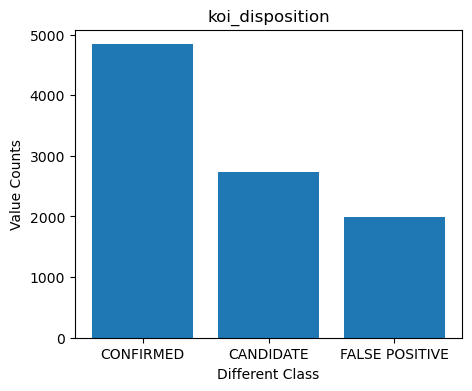

In [4]:
# Retrieve unique values from the 'koi_disposition' column in the DataFrame 'kepler' and store them in the 'classes' variable.
classes=kepler.koi_disposition.unique()
# Count the occurrences of each unique value in the 'koi_disposition' column and convert the result to a list, stored in the 'counts' variable.
counts = kepler.koi_disposition.value_counts().to_list()
# Create a bar plot using the 'classes' as x-axis values and 'counts' as y-axis values.
plt.figure(figsize=(5,4))
plt.bar(classes,counts)
plt.title('koi_disposition')
plt.xlabel('Different Class')
plt.ylabel('Value Counts')
# Print the count of each unique value in the 'koi_disposition' column.
print(kepler.koi_disposition.value_counts())

As I will work with FALSE POSITIVE and CONFIRMED values so, CANDIADTE is not important for my porject.

FALSE POSITIVE    4839
CONFIRMED         2741
Name: koi_disposition, dtype: int64


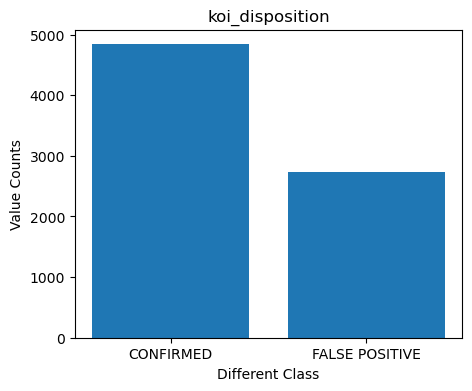

In [5]:
# Drop rows where koi_disposition is 'CANDIDATE'
kepler = kepler[kepler['koi_disposition'] != 'CANDIDATE']

# Reset the index after dropping rows
kepler.reset_index(drop=True, inplace=True)

# Retrieve unique values from the 'koi_disposition' column in the DataFrame 'kepler' and store them in the 'classes' variable.
classes=kepler.koi_disposition.unique()
counts = kepler.koi_disposition.value_counts().to_list()
plt.figure(figsize=(5,4))
plt.bar(classes,counts)
plt.title('koi_disposition')
plt.xlabel('Different Class')
plt.ylabel('Value Counts')
print(kepler.koi_disposition.value_counts())

In [6]:
# Rounding the values to two decimal places and presenting the top 30 columns with the highest percentage of missing values.
pd.DataFrame(round((kepler.isnull().sum() * 100/ len(kepler)),2).sort_values(ascending=False)).head(30)

0
koi_kepmag_err     100.00
koi_teq_err1       100.00
koi_teq_err2       100.00
kepler_name         63.81
koi_score           12.01
koi_steff_err2       4.92
koi_srad_err1        4.72
koi_slogg_err2       4.72
koi_slogg_err1       4.72
koi_steff_err1       4.72
koi_srad_err2        4.72
koi_impact_err2      4.46
koi_depth_err2       4.46
koi_depth_err1       4.46
koi_duration_err2    4.46
koi_duration_err1    4.46
koi_time0bk_err1     4.46
koi_impact_err1      4.46
koi_time0bk_err2     4.46
koi_period_err2      4.46
koi_period_err1      4.46
koi_tce_delivname    3.77
koi_tce_plnt_num     3.77
koi_slogg            3.42
koi_srad             3.42
koi_model_snr        3.42
koi_steff            3.42
koi_prad             3.42
koi_teq              3.42
koi_prad_err1        3.42

In [7]:
# Dropping rows with more than 80% data missing
kepler = kepler.dropna(thresh=len(kepler) * .80, axis=1)
kepler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7580 entries, 0 to 7579
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepoi_name         7580 non-null   object 
 1   koi_disposition    7580 non-null   object 
 2   koi_pdisposition   7580 non-null   object 
 3   koi_score          6670 non-null   float64
 4   koi_fpflag_nt      7580 non-null   int64  
 5   koi_fpflag_ss      7580 non-null   int64  
 6   koi_fpflag_co      7580 non-null   int64  
 7   koi_fpflag_ec      7580 non-null   int64  
 8   koi_period         7580 non-null   float64
 9   koi_period_err1    7242 non-null   float64
 10  koi_period_err2    7242 non-null   float64
 11  koi_time0bk        7580 non-null   float64
 12  koi_time0bk_err1   7242 non-null   float64
 13  koi_time0bk_err2   7242 non-null   float64
 14  koi_impact         7321 non-null   float64
 15  koi_impact_err1    7242 non-null   float64
 16  koi_impact_err2    7242 

In [8]:
kepler.head(10)

kepoi_name koi_disposition koi_pdisposition  koi_score  koi_fpflag_nt  \
0  K00752.01       CONFIRMED        CANDIDATE      1.000              0   
1  K00752.02       CONFIRMED        CANDIDATE      0.969              0   
2  K00754.01  FALSE POSITIVE   FALSE POSITIVE      0.000              0   
3  K00755.01       CONFIRMED        CANDIDATE      1.000              0   
4  K00756.01       CONFIRMED        CANDIDATE      1.000              0   
5  K00756.02       CONFIRMED        CANDIDATE      1.000              0   
6  K00756.03       CONFIRMED        CANDIDATE      0.992              0   
7  K00114.01  FALSE POSITIVE   FALSE POSITIVE      0.000              0   
8  K00757.01       CONFIRMED        CANDIDATE      1.000              0   
9  K00001.01       CONFIRMED        CANDIDATE      0.811              0   

   koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  koi_period  koi_period_err1  \
0              0              0              0    9.488036     2.775000e-05   
1              0              0              0   54.418383     2.479000e-04   
2              1              0              0    1.736952     2.630000e-07   
3              0              0              0    2.525592     3.761000e-06   
4              0              0              0   11.094321     2.036000e-05   
5              0              0              0    4.134435     1.046000e-05   
6              0              0              0    2.566589     1.781000e-05   
7              1              1              0    7.361790     2.128000e-05   
8              0              0              0   16.068647     1.088000e-05   
9              0              0              0    2.470613     2.700000e-08   

   ...  koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0  ...           -81.0      4.467           0.064          -0.096     0.927   
1  ...           -81.0      4.467           0.064          -0.096     0.927   
2  ...          -174.0      4.564           0.053          -0.168     0.791   
3  ...          -211.0      4.438           0.070          -0.210     1.046   
4  ...          -232.0      4.486           0.054          -0.229     0.972   
5  ...          -232.0      4.486           0.054          -0.229     0.972   
6  ...          -232.0      4.486           0.054          -0.229     0.972   
7  ...          -124.0      3.986           0.182          -0.098     1.958   
8  ...           -83.0      4.485           0.083          -0.028     0.848   
9  ...           -78.0      4.457           0.024          -0.024     0.964   

   koi_srad_err1  koi_srad_err2        ra_str       dec_str  koi_kepmag  
0          0.105         -0.061  19h27m44.22s  +48d08m29.9s      15.347  
1          0.105         -0.061  19h27m44.22s  +48d08m29.9s      15.347  
2          0.201         -0.067  19h02m08.31s  +48d17m06.8s      15.597  
3          0.334         -0.133  19h15m01.17s  +48d13m34.3s      15.509  
4          0.315         -0.105  19h45m08.67s  +48d13m28.8s      15.714  
5          0.315         -0.105  19h45m08.67s  +48d13m28.8s      15.714  
6          0.315         -0.105  19h45m08.67s  +48d13m28.8s      15.714  
7          0.322         -0.483  19h55m27.44s  +42d09m05.6s      12.660  
8          0.033         -0.072  19h07m59.88s  +48d22m32.8s      15.841  
9          0.038         -0.038  19h07m14.03s  +49d18m59.0s      11.338  

[10 rows x 45 columns]

In [9]:
# Drop the NULL values.
kepler = kepler.dropna()
kepler.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6442 entries, 0 to 7579
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepoi_name         6442 non-null   object 
 1   koi_disposition    6442 non-null   object 
 2   koi_pdisposition   6442 non-null   object 
 3   koi_score          6442 non-null   float64
 4   koi_fpflag_nt      6442 non-null   int64  
 5   koi_fpflag_ss      6442 non-null   int64  
 6   koi_fpflag_co      6442 non-null   int64  
 7   koi_fpflag_ec      6442 non-null   int64  
 8   koi_period         6442 non-null   float64
 9   koi_period_err1    6442 non-null   float64
 10  koi_period_err2    6442 non-null   float64
 11  koi_time0bk        6442 non-null   float64
 12  koi_time0bk_err1   6442 non-null   float64
 13  koi_time0bk_err2   6442 non-null   float64
 14  koi_impact         6442 non-null   float64
 15  koi_impact_err1    6442 non-null   float64
 16  koi_impact_err2    6442 

In [10]:
# Create a list of column names containing numeric data types ('int64' and 'float64') from the DataFrame 'kepler'.
numList = list(kepler.select_dtypes(include=['int64', 'float64']).columns)

# Print the list of numeric column names.
print(numList)

# Print the total number of numeric columns in the DataFrame 'kepler'.
print("Total number of numeric columns:", len(numList))

['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_kepmag']
Total number of numeric columns: 39


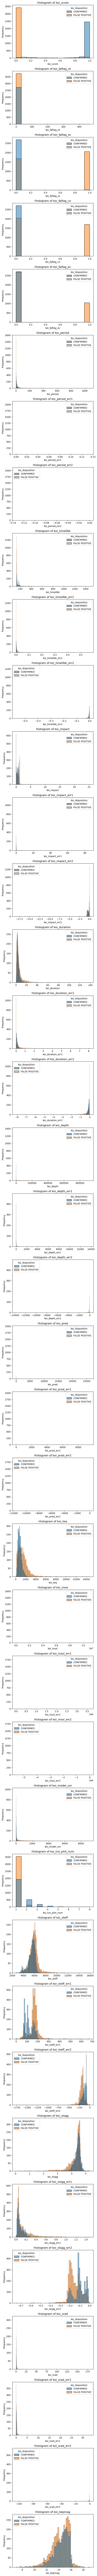

In [11]:
# Set up subplots
fig, axes = plt.subplots(nrows=len(numList), ncols=1, figsize=(6, 4 * len(numList)))

# Iterate through numeric columns and plot histograms
for i, column in enumerate(numList):
    sns.histplot(data=kepler, x=column, discrete=False, ax=axes[i], hue='koi_disposition')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Displaying the plot
plt.show()

**Anderson-Darling Test:** The Anderson-Darling test is used to assess whether a sample comes from a specific distribution, including normal distribution.

In [12]:
# Apply the Anderson-Darling Test on each numeric column
for column in numList:
    # Perform the Anderson-Darling test
    result = anderson(kepler[column])
    
    # Print the result
    print(f"\nColumn: {column}")
    print(f"Anderson-Darling Statistic: {result.statistic}")

    # Check if the data follows a normal distribution based on the 5% significance level
    if result.statistic > result.critical_values[2]:
        print("The data does not follow a normal distribution.")
    else:
        print("The data follows a normal distribution.")


Column: koi_score
Anderson-Darling Statistic: 1040.358154284424
The data does not follow a normal distribution.

Column: koi_fpflag_nt
Anderson-Darling Statistic: 2313.4889277346992
The data does not follow a normal distribution.

Column: koi_fpflag_ss
Anderson-Darling Statistic: 1355.1157905704786
The data does not follow a normal distribution.

Column: koi_fpflag_co
Anderson-Darling Statistic: 1503.4945264441449
The data does not follow a normal distribution.

Column: koi_fpflag_ec
Anderson-Darling Statistic: 1863.604683984724
The data does not follow a normal distribution.

Column: koi_period
Anderson-Darling Statistic: 1354.7938938352554
The data does not follow a normal distribution.

Column: koi_period_err1
Anderson-Darling Statistic: 2067.527125824632
The data does not follow a normal distribution.

Column: koi_period_err2
Anderson-Darling Statistic: 2067.527125824632
The data does not follow a normal distribution.

Column: koi_time0bk
Anderson-Darling Statistic: 1092.311077618

**Shapiro-Wilk Test -** The Shapiro-Wilk test is used to check if a given sample comes from a normally distributed population. This test tests the null hypothesis that the data was drawn from a normal distribution.

In [13]:
# Apply the Shapiro-Wilk Test on each numeric column
for column in numList:
    # Perform the Shapiro-Wilk test
    stat, p_value = shapiro(kepler[column])
    
    # Print the result
    print(f"\nColumn: {column}")
    print(f"Shapiro-Wilk Statistic: {stat}")
    print(f"P-value: {p_value}")

    # Check if the data follows a normal distribution based on the 5% significance level
    if p_value > 0.05:
        print("The data follows a normal distribution.")
    else:
        print("The data does not follow a normal distribution.")


Column: koi_score
Shapiro-Wilk Statistic: 0.6622628569602966
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_fpflag_nt
Shapiro-Wilk Statistic: 0.006987094879150391
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_fpflag_ss
Shapiro-Wilk Statistic: 0.5885525345802307
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_fpflag_co
Shapiro-Wilk Statistic: 0.5500572919845581
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_fpflag_ec
Shapiro-Wilk Statistic: 0.4428582191467285
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_period
Shapiro-Wilk Statistic: 0.4225813150405884
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_period_err1
Shapiro-Wilk Statistic: 0.15056449174880981
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_period_err2
Shapiro-Wilk Statistic: 0.15056031942367554
P-value: 0.0
The data does not follow a norm

### Tranformation
-------------------------

##### koi_period

Length of unique values in the 'koi_score' column: 6442


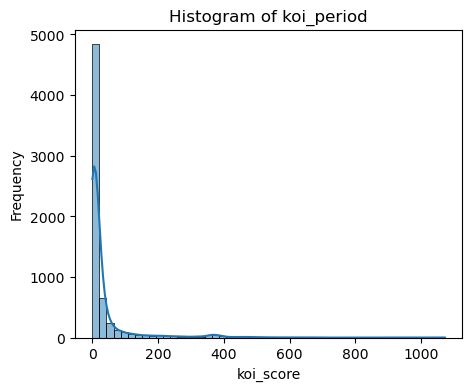

In [14]:
# Print the length of unique values in the 'koi_period' column of the DataFrame 'kepler'.
print("Length of unique values in the 'koi_score' column:", len(kepler['koi_period'].unique()))

# Create a histogram plot of the 'koi_period' column in the DataFrame 'kepler' using seaborn, with kernel density estimation and 50 bins.
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_period", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_period')
plt.xlabel('koi_score')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [15]:
# Apply logarithmic transformation
kepler['koi_period_log'] = np.log1p(kepler['koi_period'])

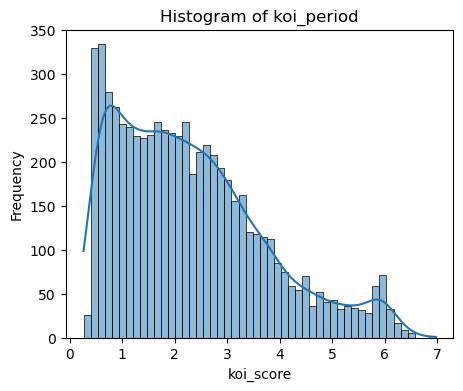

In [16]:
# Create a histogram plot of the 'koi_period_log' column.
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_period_log", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_period')
plt.xlabel('koi_score')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [17]:
# Apply Box-Cox transformation
kepler['koi_period_boxcox'], lambda_value = boxcox(kepler['koi_period'])

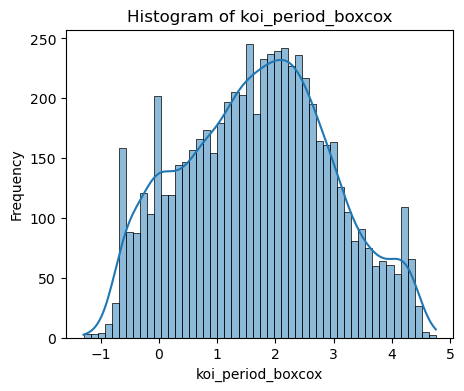

In [18]:
# Create a histogram plot of the 'koi_period_boxcox' column.
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_period_boxcox", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_period_boxcox')
plt.xlabel('koi_period_boxcox')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

Now appling BOX-Cox transformation to koi_period. Delete the 2 columns.

In [19]:
kepler['koi_period'], lambda_value = boxcox(kepler['koi_period'])
kepler = kepler.drop(['koi_period_boxcox', 'koi_period_log'], axis=1)

#### koi_period_err1

Length of unique values in the 'koi_period_err1' column: 5352


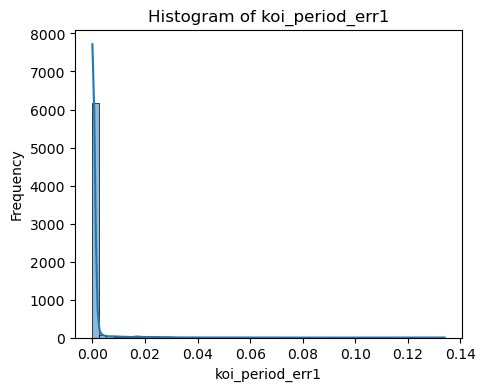

In [20]:
print("Length of unique values in the 'koi_period_err1' column:", len(kepler['koi_period_err1'].unique()))

# Create a histogram plot of the 'koi_period_err1' column.
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_period_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_period_err1')
plt.xlabel('koi_period_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [21]:
# Apply logarithmic transformation
kepler['koi_period_err1_log'] = np.log(kepler['koi_period_err1'])

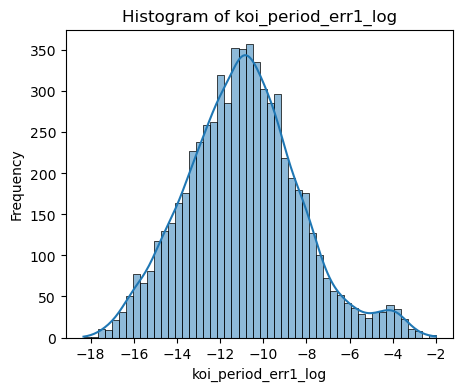

In [22]:
# Create a histogram plot of the 'koi_period_err1_log' column.
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_period_err1_log", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_period_err1_log')
plt.xlabel('koi_period_err1_log')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [23]:
# Apply Box-Cox transformation.
kepler['koi_period_err1_boxcox'], lambda_value = boxcox(kepler['koi_period_err1'])

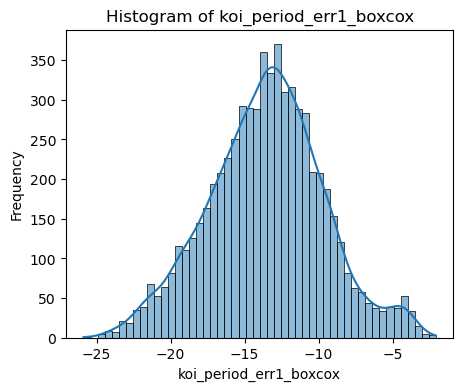

In [24]:
# Create a histogram plot of the 'koi_period_err1_boxcox' column
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_period_err1_boxcox", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_period_err1_boxcox')
plt.xlabel('koi_period_err1_boxcox')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [25]:
# Apply the natural logarithm to the 'koi_period_err1' column in the DataFrame 'kepler'.
kepler['koi_period_err1'] = np.log(kepler['koi_period_err1'])
# Drop the specified columns ('koi_period_err1_log' and 'koi_period_err1_boxcox') from the DataFrame 'kepler'.
kepler = kepler.drop(['koi_period_err1_log', 'koi_period_err1_boxcox'], axis=1)

#### koi_period_err2

Length of unique values in the 'koi_period_err2' column: 5352


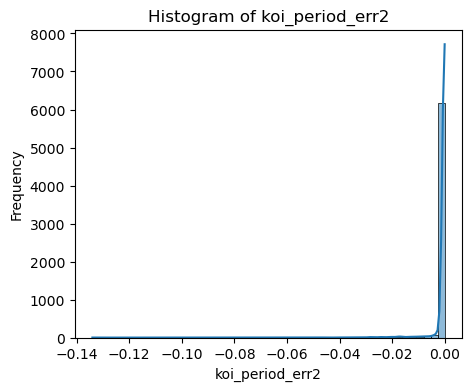

In [26]:
# Print the length of unique values in the 'koi_period_err2' column of the DataFrame 'kepler'.
print("Length of unique values in the 'koi_period_err2' column:", len(kepler['koi_period_err2'].unique()))

# Create a histogram plot of the 'koi_period_err2' column in the DataFrame 'kepler' using seaborn.
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_period_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_period_err2')
plt.xlabel('koi_period_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [27]:
# Apply logarithmic transformation
kepler['koi_period_err2_exp'] = np.exp(kepler['koi_period_err2'])

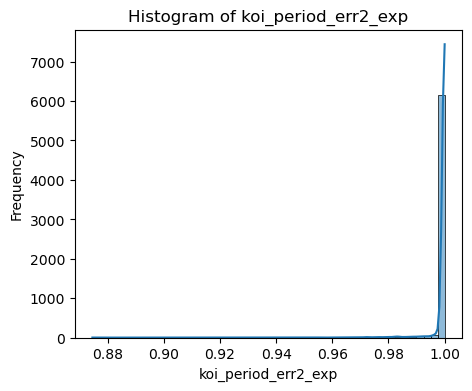

In [28]:
# Create a histogram plot of the 'koi_period_err2_exp' column in the DataFrame 'kepler' using seaborn
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_period_err2_exp", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_period_err2_exp')
plt.xlabel('koi_period_err2_exp')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [29]:
# Apply log-odds transformation
kepler['koi_period_err2_logodds'] = np.log(1 / (1 - kepler['koi_period_err2']))

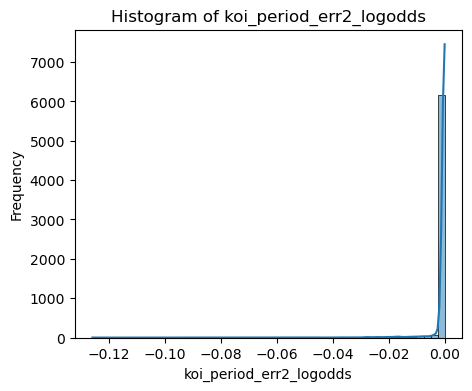

In [30]:
# Create a histogram plot of the 'koi_period_err2_logodds' column in the DataFrame 'kepler' using seaborn
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_period_err2_logodds", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_period_err2_logodds')
plt.xlabel('koi_period_err2_logodds')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [31]:
kepler['koi_period_err2'] = np.exp(kepler['koi_period_err2'])
kepler = kepler.drop(['koi_period_err2_exp', 'koi_period_err2_logodds'], axis=1)

In [32]:
kepler.shape

(6442, 45)

#### koi_time0bk

Length of unique values in the 'koi_time0bk' column: 6430


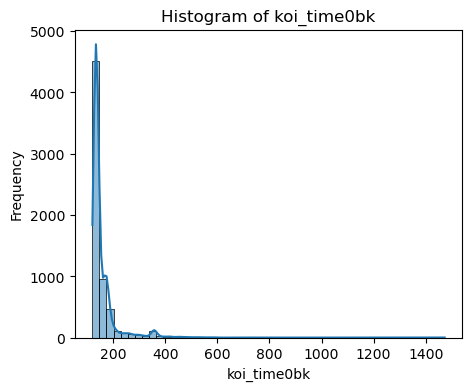

In [33]:
print("Length of unique values in the 'koi_time0bk' column:", len(kepler['koi_time0bk'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_time0bk", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_time0bk')
plt.xlabel('koi_time0bk')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [34]:
# Apply logarithmic transformation
kepler['koi_time0bk_log'] = np.log(kepler['koi_time0bk'])

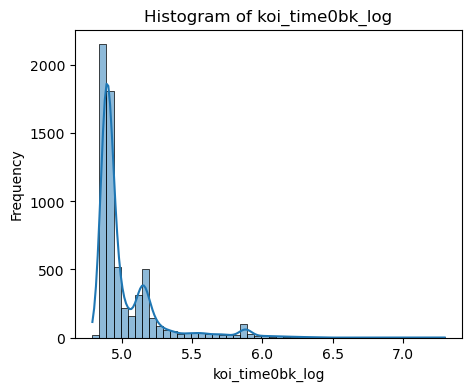

In [35]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_time0bk_log", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_time0bk_log')
plt.xlabel('koi_time0bk_log')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [36]:
# Apply Box-Cox transformation
kepler['koi_time0bk_boxcox'], lambda_value = boxcox(kepler['koi_time0bk'])

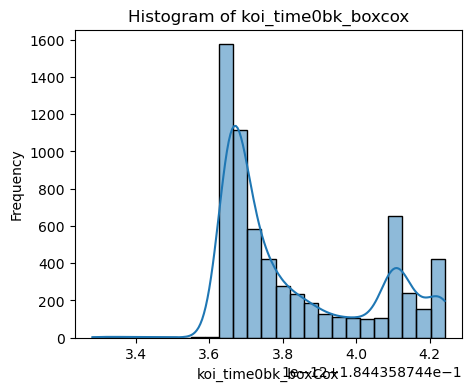

In [37]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_time0bk_boxcox", discrete = False, kde = True)
plt.title('Histogram of koi_time0bk_boxcox')
plt.xlabel('koi_time0bk_boxCox')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [38]:
kepler['koi_time0bk'] = np.log(kepler['koi_time0bk'])
kepler = kepler.drop(['koi_time0bk_boxcox', 'koi_time0bk_log'], axis=1)

In [39]:
kepler.shape

(6442, 45)

#### koi_time0bk_err1

Length of unique values in the 'koi_time0bk_err1' column: 2227


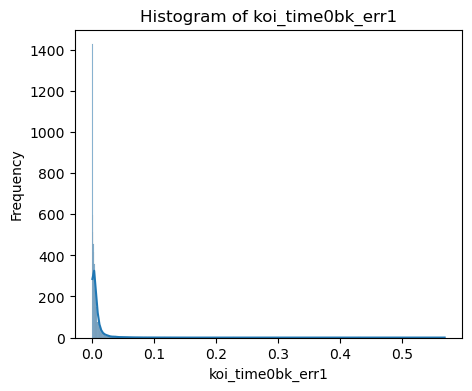

In [40]:
print("Length of unique values in the 'koi_time0bk_err1' column:", len(kepler['koi_time0bk_err1'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_time0bk_err1", discrete = False, kde = True)
plt.title('Histogram of koi_time0bk_err1')
plt.xlabel('koi_time0bk_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

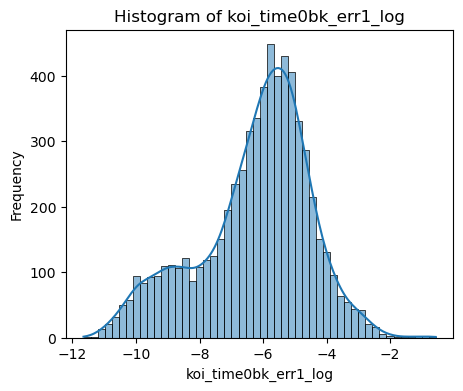

In [41]:
# Apply logarithmic transformation
kepler['koi_time0bk_err1_log'] = np.log(kepler['koi_time0bk_err1'])

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_time0bk_err1_log", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_time0bk_err1_log')
plt.xlabel('koi_time0bk_err1_log')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [42]:
# Apply Box-Cox transformation
kepler['koi_time0bk_err1_boxcox'], lambda_value = boxcox(kepler['koi_time0bk_err1'])

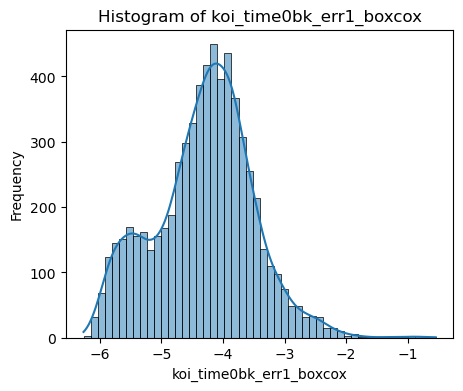

In [43]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_time0bk_err1_boxcox", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_time0bk_err1_boxcox')
plt.xlabel('koi_time0bk_err1_boxcox')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [44]:
# Apply Box-Cox transformation
kepler['koi_time0bk_err1'], lambda_value = boxcox(kepler['koi_time0bk_err1'])
kepler = kepler.drop(['koi_time0bk_err1_boxcox', 'koi_time0bk_err1_log'], axis=1)

In [45]:
kepler.shape

(6442, 45)

#### koi_time0bk_err2

Length of unique values in the 'koi_time0bk_err2' column: 2227


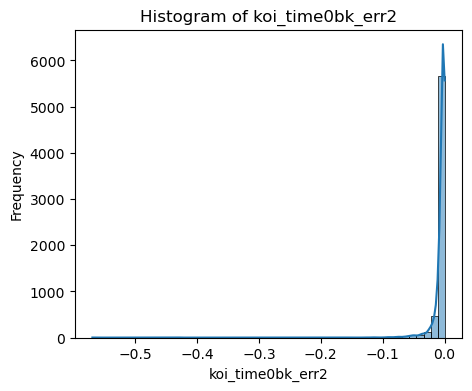

In [46]:
print("Length of unique values in the 'koi_time0bk_err2' column:", len(kepler['koi_time0bk_err2'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_time0bk_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_time0bk_err2')
plt.xlabel('koi_time0bk_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [47]:
# Apply exponential transformation
kepler['koi_time0bk_err2'] = np.exp(kepler['koi_time0bk_err2'])

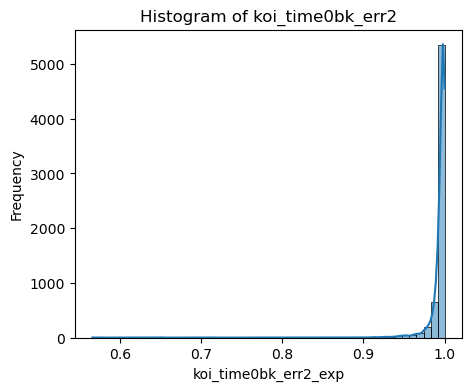

In [48]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_time0bk_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_time0bk_err2')
plt.xlabel('koi_time0bk_err2_exp')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [49]:
kepler.shape

(6442, 45)

#### koi_impact

Length of unique values in the 'koi_impact' column: 1357


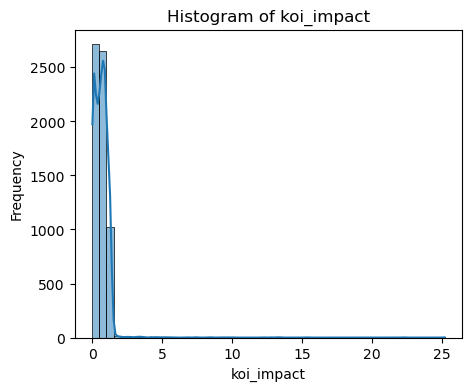

In [50]:
print("Length of unique values in the 'koi_impact' column:", len(kepler['koi_impact'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_impact", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_impact')
plt.xlabel('koi_impact')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [51]:
# Apply logarithmic transformation
kepler['koi_impact'] = np.log(kepler['koi_impact'])

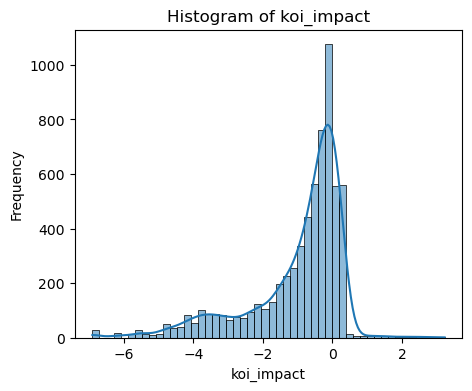

In [52]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_impact", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_impact')
plt.xlabel('koi_impact')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [53]:
kepler.shape

(6442, 45)

#### koi_impact_err1

Length of unique values in the 'koi_impact_err1' column: 1167


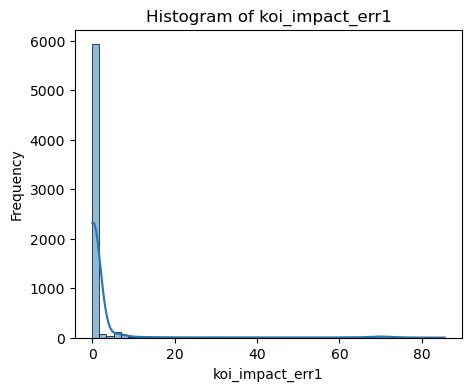

In [54]:
print("Length of unique values in the 'koi_impact_err1' column:", len(kepler['koi_impact_err1'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_impact_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_impact_err1')
plt.xlabel('koi_impact_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [55]:
kepler['koi_impact_err1'] = np.log(kepler['koi_impact_err1'])

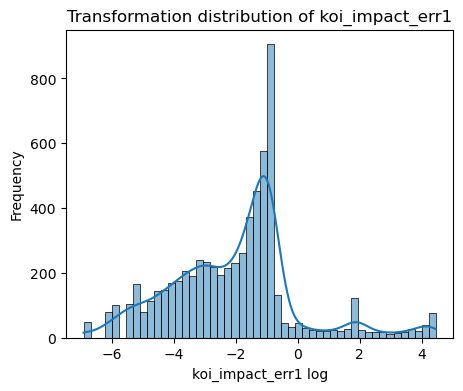

In [56]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_impact_err1", discrete = False, kde = True, bins= 50)
plt.title('Transformation distribution of koi_impact_err1')
plt.xlabel('koi_impact_err1 log')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [57]:
kepler.shape

(6442, 45)

#### koi_impact_err2

Length of unique values in the 'koi_impact_err2' column: 839


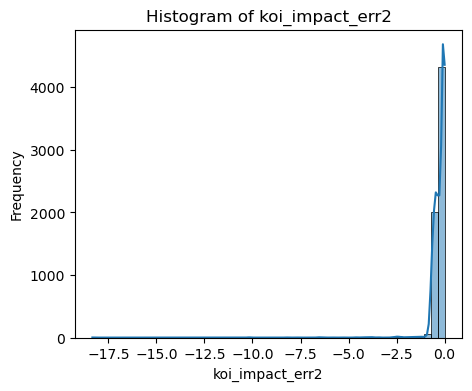

In [58]:
print("Length of unique values in the 'koi_impact_err2' column:", len(kepler['koi_impact_err2'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_impact_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_impact_err2')
plt.xlabel('koi_impact_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [59]:
# Apply exponential transformation
kepler['koi_impact_err2'] = np.exp(kepler['koi_impact_err2'])

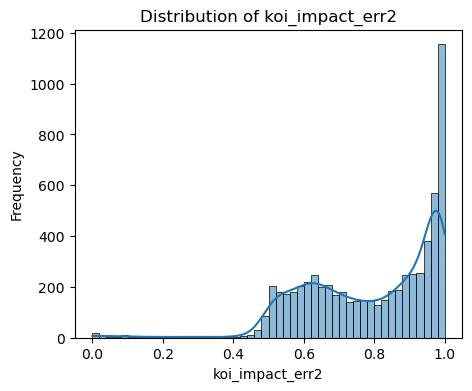

In [60]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_impact_err2", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_impact_err2')
plt.xlabel('koi_impact_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_duration

Length of unique values in the 'koi_duration' column: 5850


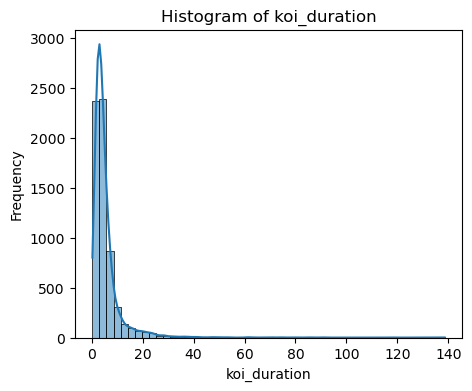

In [61]:
print("Length of unique values in the 'koi_duration' column:", len(kepler['koi_duration'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_duration", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_duration')
plt.xlabel('koi_duration')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [62]:
kepler['koi_duration'] = np.log(kepler['koi_duration'])

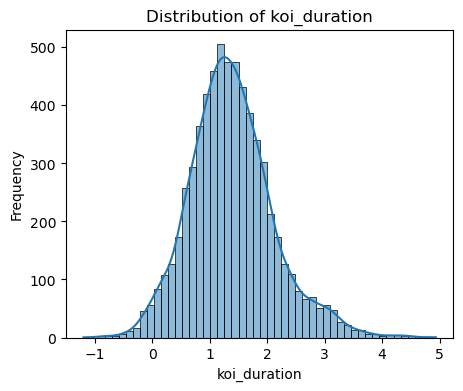

In [63]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_duration", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_duration')
plt.xlabel('koi_duration')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_duration_err1

Length of unique values in the 'koi_duration_err1' column: 2027


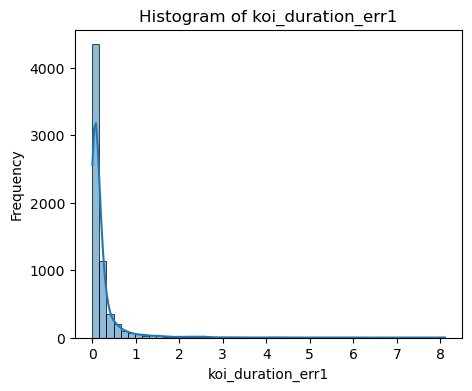

In [64]:
print("Length of unique values in the 'koi_duration_err1' column:", len(kepler['koi_duration_err1'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_duration_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_duration_err1')
plt.xlabel('koi_duration_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [65]:
kepler['koi_duration_err1'] = np.log(kepler['koi_duration_err1'])

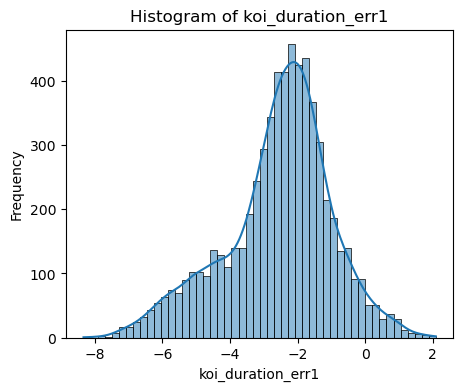

In [66]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_duration_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_duration_err1')
plt.xlabel('koi_duration_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_duration_err2

Length of unique values in the 'koi_duration_err2' column: 2027


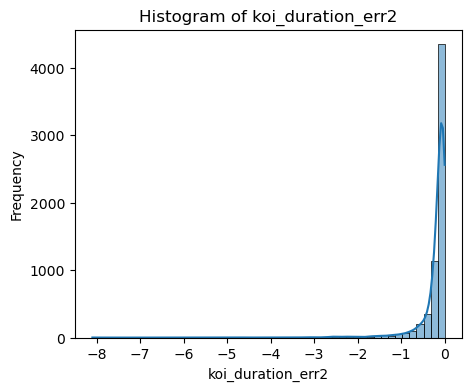

In [67]:
print("Length of unique values in the 'koi_duration_err2' column:", len(kepler['koi_duration_err2'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_duration_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_duration_err2')
plt.xlabel('koi_duration_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [68]:
# Apply exponential transformation
kepler['koi_duration_err2'] = np.exp(kepler['koi_duration_err2'])

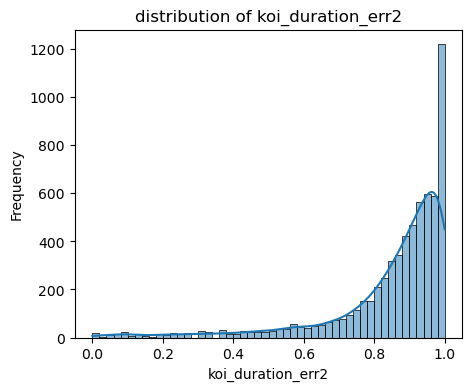

In [69]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_duration_err2", discrete = False, kde = True, bins= 50)
plt.title('distribution of koi_duration_err2')
plt.xlabel('koi_duration_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_depth

Length of unique values in the 'koi_depth' column: 5499


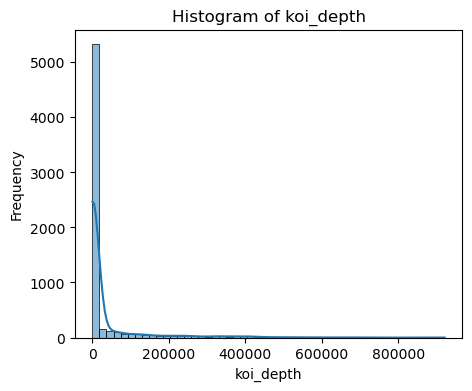

In [70]:
print("Length of unique values in the 'koi_depth' column:", len(kepler['koi_depth'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_depth", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_depth')
plt.xlabel('koi_depth')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [71]:
kepler['koi_depth'] = np.log(kepler['koi_depth'])

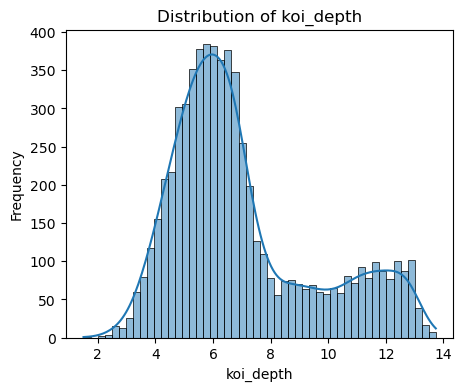

In [72]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_depth", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_depth')
plt.xlabel('koi_depth')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [73]:
kepler.shape

(6442, 45)

#### koi_depth_err1

Length of unique values in the 'koi_depth_err1' column: 1254


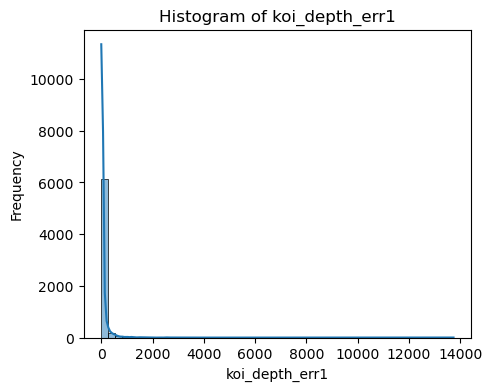

In [74]:
print("Length of unique values in the 'koi_depth_err1' column:", len(kepler['koi_depth_err1'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_depth_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_depth_err1')
plt.xlabel('koi_depth_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [75]:
kepler['koi_depth_err1'] = np.log(kepler['koi_depth_err1'])

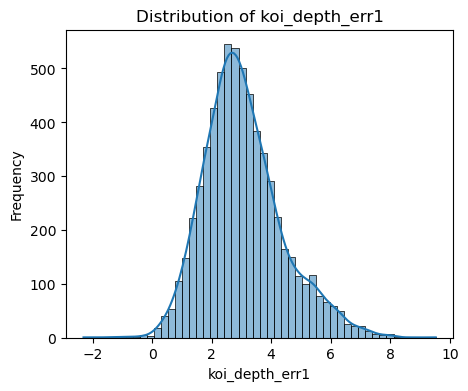

In [76]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_depth_err1", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_depth_err1')
plt.xlabel('koi_depth_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_depth_err2

Length of unique values in the 'koi_depth_err2' column: 1254


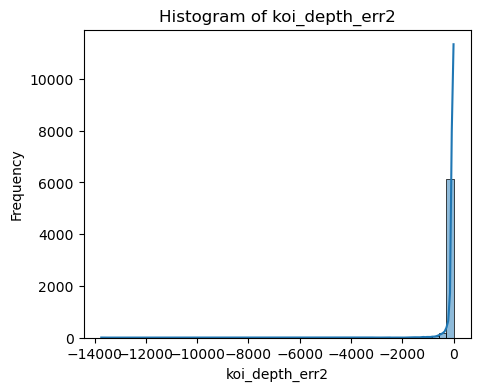

In [77]:
print("Length of unique values in the 'koi_depth_err2' column:", len(kepler['koi_depth_err2'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_depth_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_depth_err2')
plt.xlabel('koi_depth_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [78]:
# Apply exponential transformation
kepler['koi_depth_err2'] = np.exp(kepler['koi_depth_err2'])

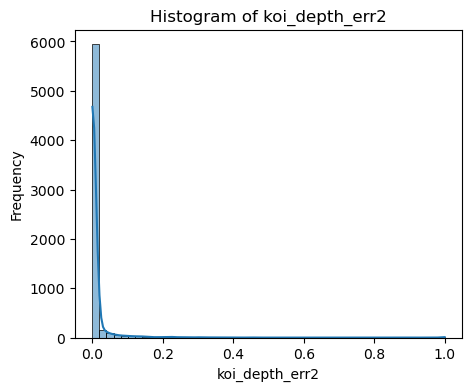

In [79]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_depth_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_depth_err2')
plt.xlabel('koi_depth_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [80]:
kepler.shape

(6442, 45)

#### koi_prad

Length of unique values in the 'koi_prad' column: 2595


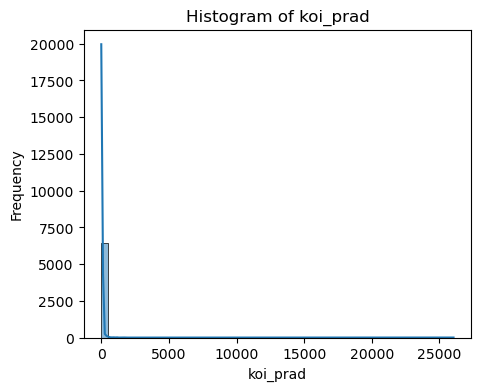

In [81]:
print("Length of unique values in the 'koi_prad' column:", len(kepler['koi_prad'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_prad", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_prad')
plt.xlabel('koi_prad')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [82]:
kepler['koi_prad_log'] = np.log(kepler['koi_prad'])

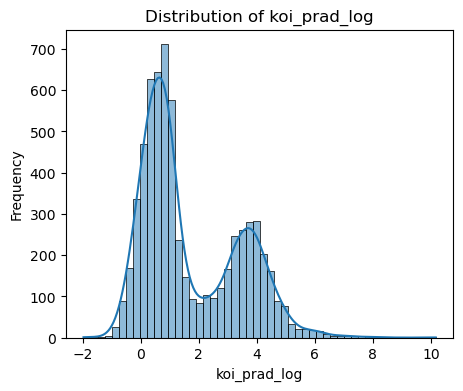

In [83]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_prad_log", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_prad_log')
plt.xlabel('koi_prad_log')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [84]:
kepler['koi_prad_boxcox'], lambda_value = boxcox(kepler['koi_prad'])

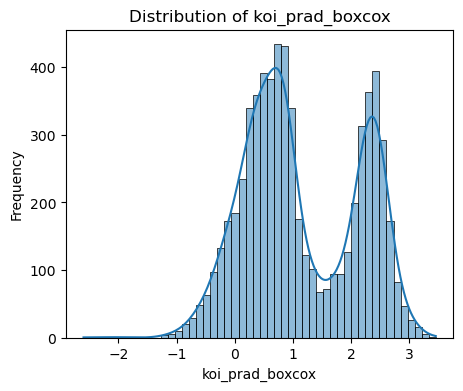

In [85]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_prad_boxcox", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_prad_boxcox')
plt.xlabel('koi_prad_boxcox')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [86]:
kepler['koi_prad'] = np.log(kepler['koi_prad'])
kepler = kepler.drop(['koi_prad_boxcox', 'koi_prad_log'], axis=1)

In [87]:
kepler.shape

(6442, 45)

#### koi_prad_err1

Length of unique values in the 'koi_prad_err1' column: 1650


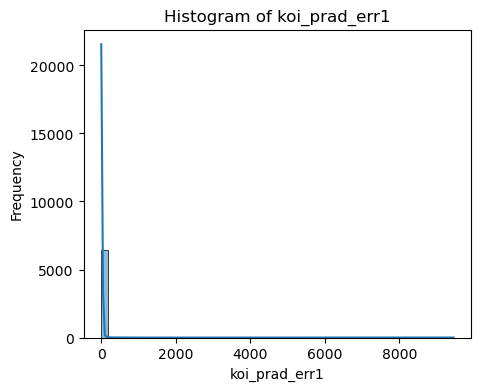

In [88]:
print("Length of unique values in the 'koi_prad_err1' column:", len(kepler['koi_prad_err1'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_prad_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_prad_err1')
plt.xlabel('koi_prad_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [89]:
kepler['koi_prad_err1'] = np.log(kepler['koi_prad_err1'])

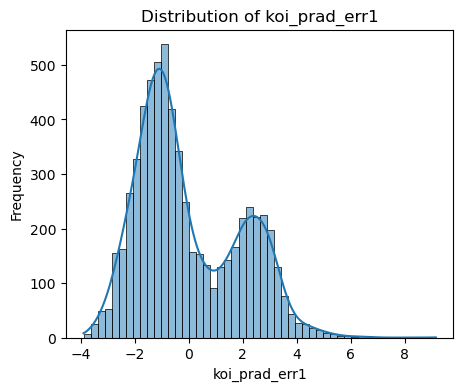

In [90]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_prad_err1", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_prad_err1')
plt.xlabel('koi_prad_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_prad_err2

Length of unique values in the 'koi_prad_err2' column: 1443


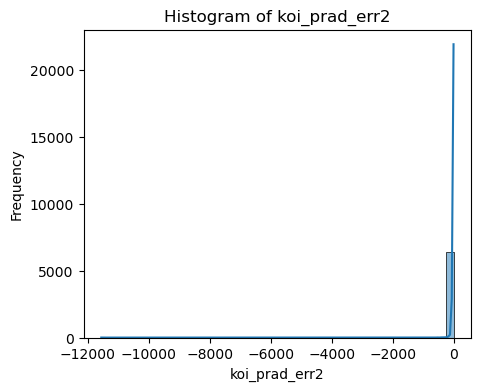

In [91]:
print("Length of unique values in the 'koi_prad_err2' column:", len(kepler['koi_prad_err2'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_prad_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_prad_err2')
plt.xlabel('koi_prad_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [92]:
kepler['koi_prad_err2'] = np.exp(kepler['koi_prad_err2'])

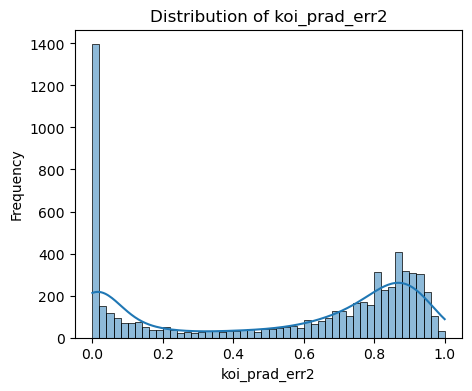

In [93]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_prad_err2", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_prad_err2')
plt.xlabel('koi_prad_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_teq

Length of unique values in the 'koi_teq' column: 2301


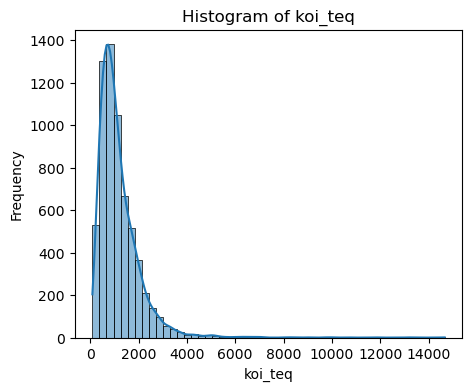

In [94]:
print("Length of unique values in the 'koi_teq' column:", len(kepler['koi_teq'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_teq", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_teq')
plt.xlabel('koi_teq')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [95]:
kepler['koi_teq'] = np.log(kepler['koi_teq'])

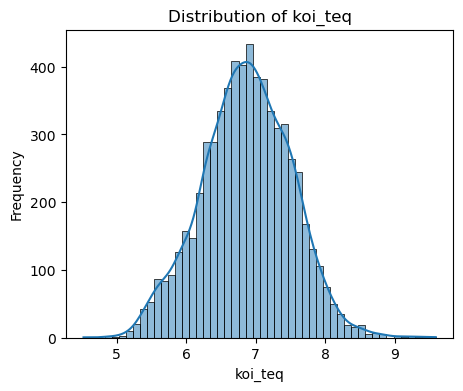

In [96]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_teq", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_teq')
plt.xlabel('koi_teq')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [97]:
kepler.shape

(6442, 45)

#### koi_insol

Length of unique values in the 'koi_insol' column: 5950


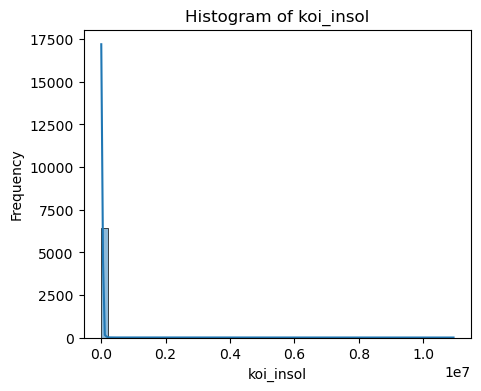

In [98]:
print("Length of unique values in the 'koi_insol' column:", len(kepler['koi_insol'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_insol", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_insol')
plt.xlabel('koi_insol')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [99]:
kepler['koi_insol'] = np.log(kepler['koi_insol'])

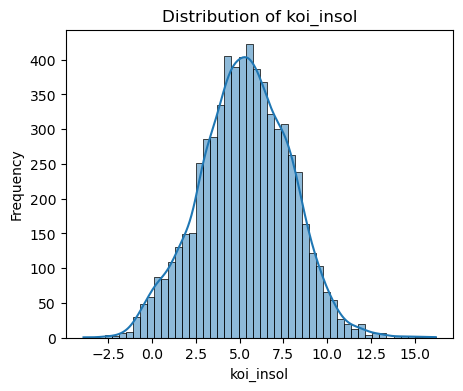

In [100]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_insol", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_insol')
plt.xlabel('koi_insol')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [101]:
kepler.shape

(6442, 45)

#### koi_insol_err1

Length of unique values in the 'koi_insol_err1' column: 5592


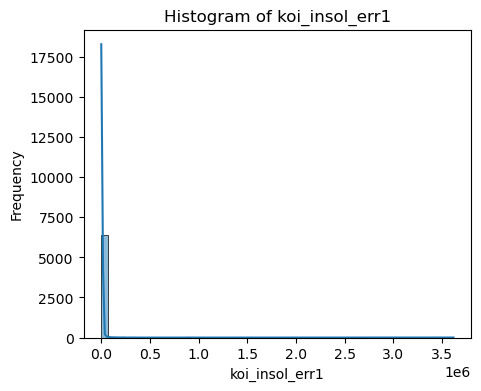

In [102]:
print("Length of unique values in the 'koi_insol_err1' column:", len(kepler['koi_insol_err1'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_insol_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_insol_err1')
plt.xlabel('koi_insol_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [103]:
kepler['koi_insol_err1'] = np.log(kepler['koi_insol_err1'])

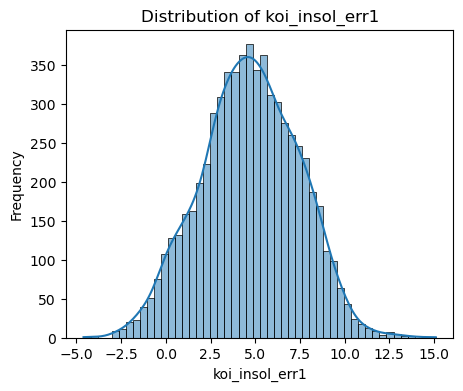

In [104]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_insol_err1", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_insol_err1')
plt.xlabel('koi_insol_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [105]:
kepler.shape

(6442, 45)

#### koi_insol_err2

Length of unique values in the 'koi_insol_err2' column: 5247


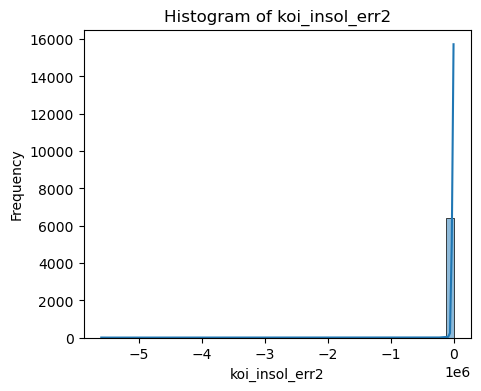

In [106]:
print("Length of unique values in the 'koi_insol_err2' column:", len(kepler['koi_insol_err2'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_insol_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_insol_err2')
plt.xlabel('koi_insol_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [107]:
kepler['koi_insol_err2'] = np.exp(kepler['koi_insol_err2'])

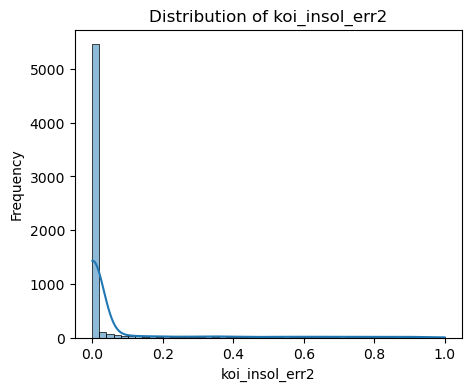

In [108]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_insol_err2", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_insol_err2')
plt.xlabel('koi_insol_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [109]:
kepler.shape

(6442, 45)

#### koi_model_snr

Length of unique values in the 'koi_model_snr' column: 2518


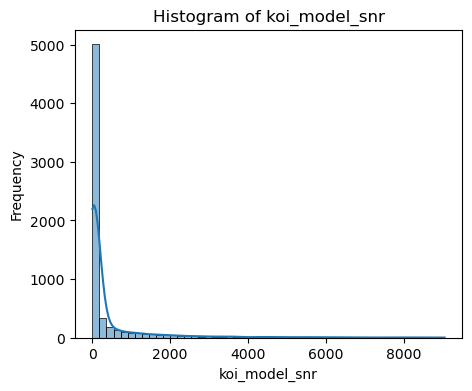

In [110]:
print("Length of unique values in the 'koi_model_snr' column:", len(kepler['koi_model_snr'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_model_snr", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_model_snr')
plt.xlabel('koi_model_snr')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [111]:
kepler['koi_model_snr'] = np.log(kepler['koi_model_snr'])

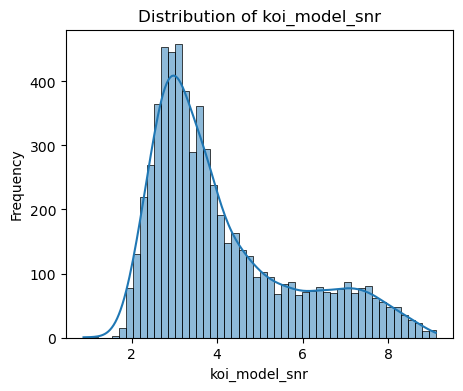

In [112]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_model_snr", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_model_snr')
plt.xlabel('koi_model_snr')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [113]:
kepler.shape

(6442, 45)

#### koi_steff

Length of unique values in the 'koi_steff' column: 2141


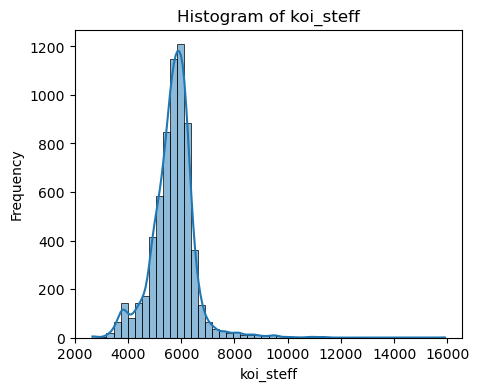

In [114]:
print("Length of unique values in the 'koi_steff' column:", len(kepler['koi_steff'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_steff", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_steff')
plt.xlabel('koi_steff')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [115]:
kepler['koi_steff'] = np.log(kepler['koi_steff'])

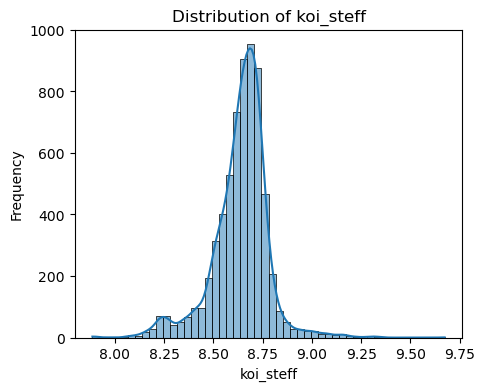

In [116]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_steff", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_steff')
plt.xlabel('koi_steff')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [117]:
kepler.shape

(6442, 45)

#### koi_steff_err1

Length of unique values in the 'koi_steff_err1' column: 250


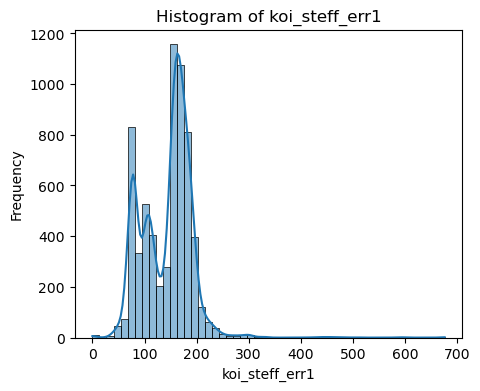

In [118]:
print("Length of unique values in the 'koi_steff_err1' column:", len(kepler['koi_steff_err1'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_steff_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_steff_err1')
plt.xlabel('koi_steff_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [119]:
kepler['koi_steff_err1'] = np.log(kepler['koi_steff_err1'])

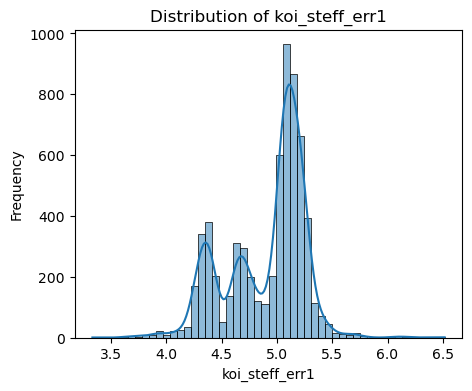

In [120]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_steff_err1", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_steff_err1')
plt.xlabel('koi_steff_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [121]:
kepler.shape

(6442, 45)

#### koi_steff_err2

Length of unique values in the 'koi_steff_err2' column: 349


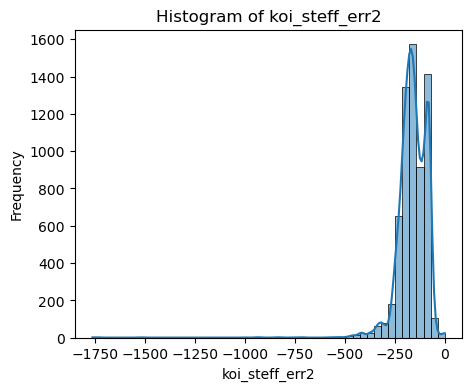

In [122]:
print("Length of unique values in the 'koi_steff_err2' column:", len(kepler['koi_steff_err2'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_steff_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_steff_err2')
plt.xlabel('koi_steff_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [123]:
kepler['koi_steff_err2_exp'] = np.exp(kepler['koi_steff_err2'])

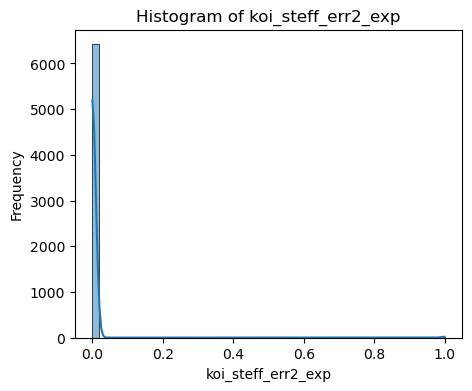

In [124]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_steff_err2_exp", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_steff_err2_exp')
plt.xlabel('koi_steff_err2_exp')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [125]:
kepler.drop(['koi_steff_err2_exp'], axis=1, inplace=True)

In [126]:
kepler.shape

(6442, 45)

#### koi_slogg

Length of unique values in the 'koi_slogg' column: 1334


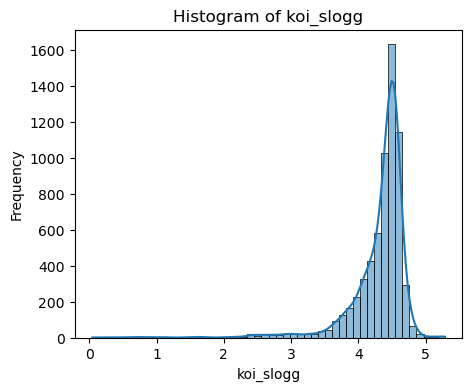

In [127]:
print("Length of unique values in the 'koi_slogg' column:", len(kepler['koi_slogg'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_slogg", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_slogg')
plt.xlabel('koi_slogg')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [128]:
kepler['koi_slogg'] = np.exp(kepler['koi_slogg'])

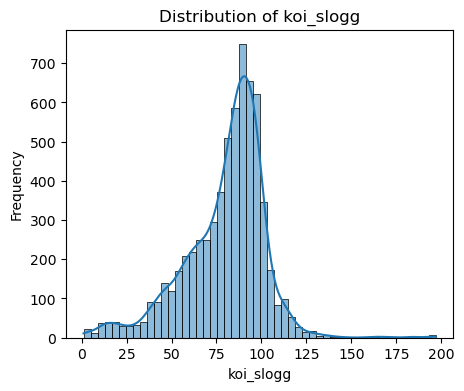

In [129]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_slogg", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_slogg')
plt.xlabel('koi_slogg')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [130]:
kepler.shape

(6442, 45)

#### koi_slogg_err1

Length of unique values in the 'koi_slogg_err1' column: 434


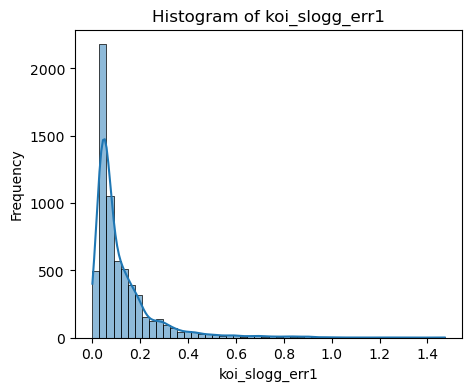

In [131]:
print("Length of unique values in the 'koi_slogg_err1' column:", len(kepler['koi_slogg_err1'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_slogg_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_slogg_err1')
plt.xlabel('koi_slogg_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [132]:
kepler['koi_slogg_err1'] = np.log(kepler['koi_slogg_err1'])

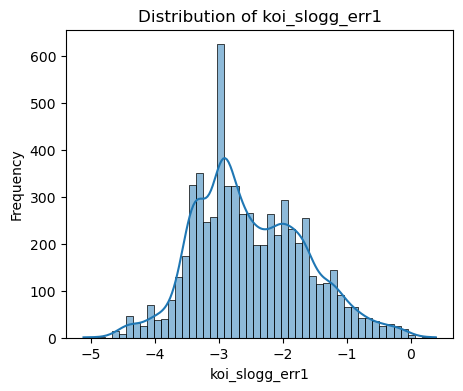

In [133]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_slogg_err1", discrete = False, kde = True, bins= 50)
plt.title('Distribution of koi_slogg_err1')
plt.xlabel('koi_slogg_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_slogg_err2

Length of unique values in the 'koi_slogg_err2' column: 287


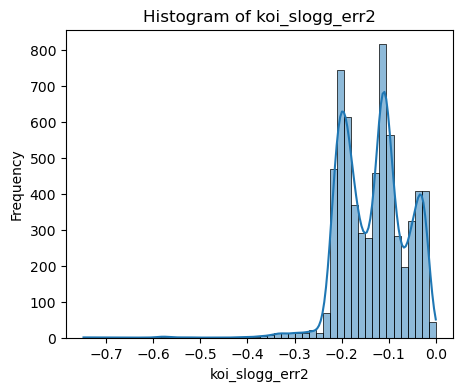

In [134]:
print("Length of unique values in the 'koi_slogg_err2' column:", len(kepler['koi_slogg_err2'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_slogg_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_slogg_err2')
plt.xlabel('koi_slogg_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [135]:
kepler['koi_slogg_err2_log'] = np.log(kepler['koi_slogg_err2'])

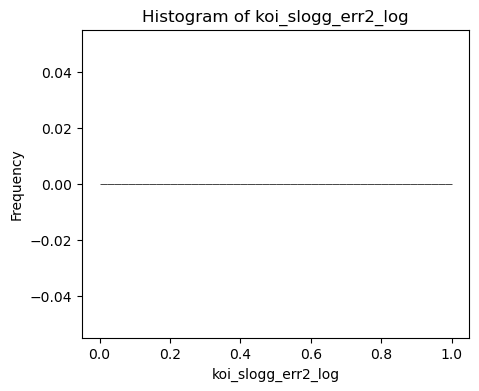

In [136]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_slogg_err2_log", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_slogg_err2_log')
plt.xlabel('koi_slogg_err2_log')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [137]:
kepler['koi_slogg_err2_exp'] = np.exp(kepler['koi_slogg_err2'])

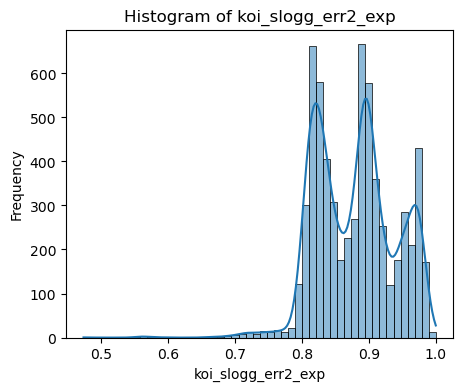

In [138]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_slogg_err2_exp", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_slogg_err2_exp')
plt.xlabel('koi_slogg_err2_exp')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [139]:
kepler['koi_slogg_err2'] = np.exp(kepler['koi_slogg_err2'])
kepler = kepler.drop(['koi_slogg_err2_log', 'koi_slogg_err2_exp'], axis=1)

In [140]:
kepler.shape

(6442, 45)

#### koi_srad

Length of unique values in the 'koi_srad' column: 1904


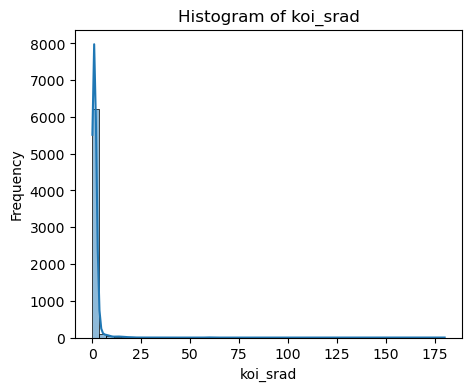

In [141]:
print("Length of unique values in the 'koi_srad' column:", len(kepler['koi_srad'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_srad", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_srad')
plt.xlabel('koi_srad')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [142]:
kepler['koi_srad'] = np.log(kepler['koi_srad'])

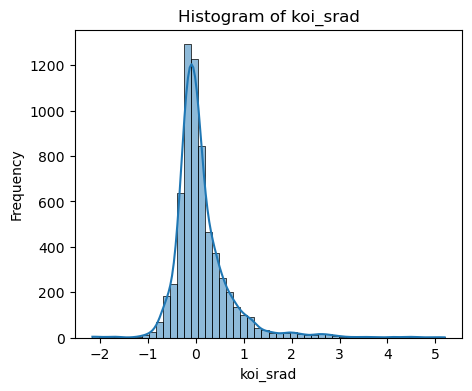

In [143]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_srad", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_srad')
plt.xlabel('koi_srad')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_srad_err1

Length of unique values in the 'koi_srad_err1' column: 870


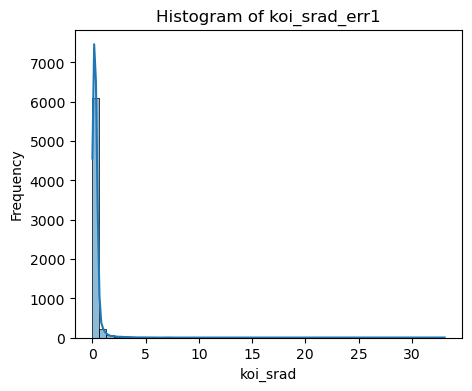

In [144]:
print("Length of unique values in the 'koi_srad_err1' column:", len(kepler['koi_srad_err1'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_srad_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_srad_err1')
plt.xlabel('koi_srad')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [145]:
kepler['koi_srad_err1'] = np.log(kepler['koi_srad_err1'])

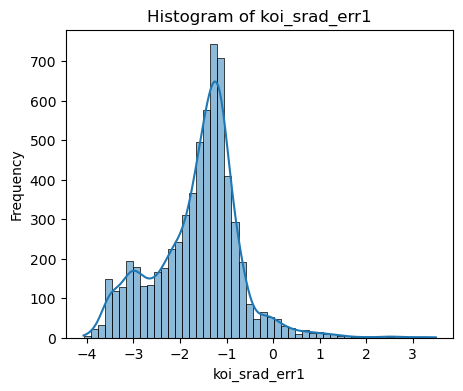

In [146]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_srad_err1", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_srad_err1')
plt.xlabel('koi_srad_err1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_srad_err2

Length of unique values in the 'koi_srad_err2' column: 1116


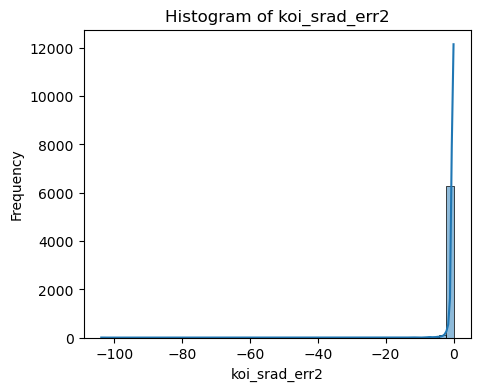

In [147]:
print("Length of unique values in the 'koi_srad_err2' column:", len(kepler['koi_srad_err2'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_srad_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_srad_err2')
plt.xlabel('koi_srad_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [148]:
kepler['koi_srad_err2'] = np.exp(kepler['koi_srad_err2'])

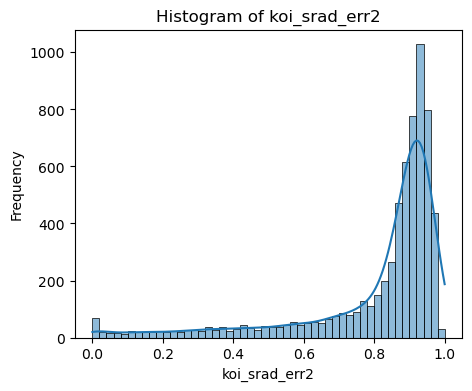

In [149]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_srad_err2", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_srad_err2')
plt.xlabel('koi_srad_err2')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

#### koi_kepmag

Length of unique values in the 'koi_kepmag' column: 3185


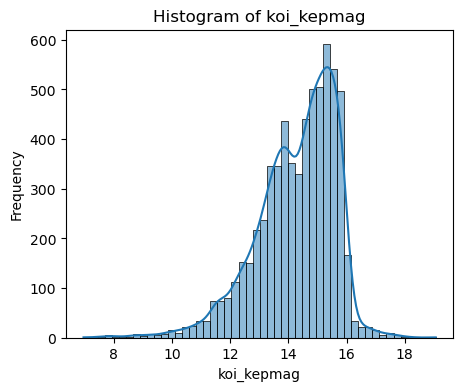

In [150]:
print("Length of unique values in the 'koi_kepmag' column:", len(kepler['koi_kepmag'].unique()))

plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_kepmag", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_kepmag')
plt.xlabel('koi_kepmag')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [151]:
kepler['koi_kepmag_log'] = np.log(kepler['koi_kepmag'])

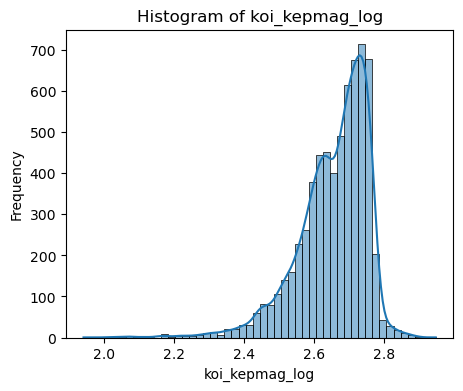

In [152]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_kepmag_log", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_kepmag_log')
plt.xlabel('koi_kepmag_log')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [153]:
kepler['koi_kepmag_exp'] = np.exp(kepler['koi_kepmag'])

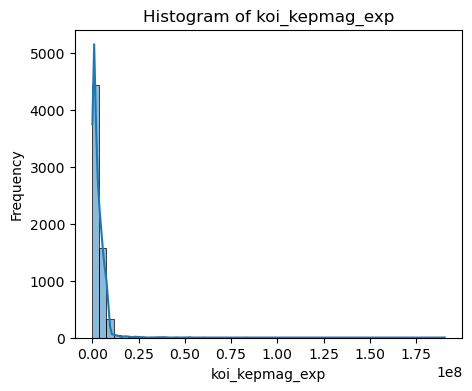

In [154]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "koi_kepmag_exp", discrete = False, kde = True, bins= 50)
plt.title('Histogram of koi_kepmag_exp')
plt.xlabel('koi_kepmag_exp')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [155]:
kepler['koi_kepmag'] = np.log(kepler['koi_kepmag'])
kepler = kepler.drop(['koi_kepmag_log', 'koi_kepmag_exp'], axis=1)

In [156]:
kepler.shape

(6442, 45)

### Convertion

In [157]:
object_columns = kepler.select_dtypes(include=['object']).columns
print(object_columns)

Index(['kepoi_name', 'koi_disposition', 'koi_pdisposition',
       'koi_tce_delivname', 'ra_str', 'dec_str'],
      dtype='object')


##### kepoi_name

In [158]:
# Check how many unique values are there.
print("Number of Unique Values in kepoi_name:", len(kepler.kepoi_name.unique()))

Number of Unique Values in kepoi_name: 6442


In the "kepoi_name" column has all of the unique values, so I can drop the column.

In [159]:
kepler = kepler.drop(['kepoi_name'],1).reset_index(drop=True)
kepler.shape

(6442, 44)

##### koi_pdisposition

['CANDIDATE' 'FALSE POSITIVE']


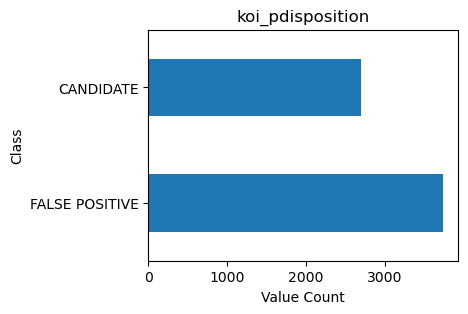

In [160]:
print(kepler.koi_pdisposition.unique())

# Plotting the horizontal bar chart
kepler.koi_pdisposition.value_counts().plot(kind='barh', figsize=(4, 3))
# Adding title, x-label, and y-label
plt.title('koi_pdisposition')
plt.xlabel('Value Count')
plt.ylabel('Class')
# Display the plot
plt.show()

- The koi_pdisposition column represents the disposition of the KOI based on a priori information before being confirmed.

koi_pdisposition is not useful for my future work.

In [161]:
kepler = kepler.drop(['koi_pdisposition'],1).reset_index(drop=True)
kepler.shape

(6442, 43)

##### koi_tce_delivname

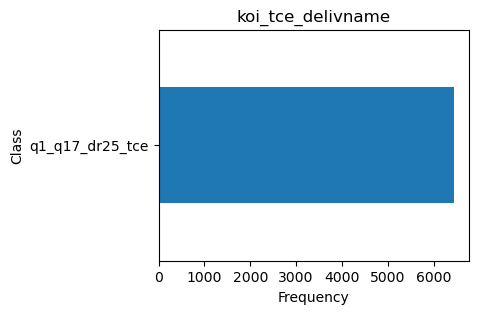

In [162]:
# Plotting the horizontal bar chart
kepler.koi_tce_delivname.value_counts().plot(kind='barh', figsize=(4,3))
# Adding title, x-label, and y-label
plt.title('koi_tce_delivname')
plt.xlabel('Frequency')
plt.ylabel('Class')
# Display the plot
plt.show()

"koi_tce_delivname" column has only one unique valus so I can drop that.

In [163]:
kepler = kepler.drop(['koi_tce_delivname'],1).reset_index(drop=True)
kepler.shape

(6442, 42)

##### ra_str

In [164]:
print("Unique values are: ",kepler.ra_str.unique())

print("Number of Unique values are: ", len(kepler.ra_str.unique()))

Unique values are:  ['19h27m44.22s' '19h02m08.31s' '19h15m01.17s' ... '19h48m45.30s'
 '19h36m39.57s' '19h48m02.34s']
Number of Unique values are:  5577


In [165]:
# Function to convert sexagesimal string to decimal degrees
def sexagesimal_to_degrees(sexagesimal):
    parts = sexagesimal.split('h')
    hours = float(parts[0])
    parts = parts[1].split('m')
    minutes = float(parts[0])
    parts = parts[1].split('s')
    seconds = float(parts[0])
    
    degrees = hours * 15 + minutes * 0.25 + seconds * (1/240)
    return degrees

# Apply the conversion function to the "ra_str" column
kepler['ra_deg'] = kepler['ra_str'].apply(sexagesimal_to_degrees)
# Now you have a new column "ra_deg" with the Right Ascension in decimal degrees

In [166]:
# Display the DataFrame with the new numeric 'dec_numeric' column
print(kepler[['ra_str', 'ra_deg']])

            ra_str      ra_deg
0     19h27m44.22s  291.934250
1     19h27m44.22s  291.934250
2     19h02m08.31s  285.534625
3     19h15m01.17s  288.754875
4     19h45m08.67s  296.286125
...            ...         ...
6437  19h23m44.63s  290.935958
6438  19h54m59.81s  298.749208
6439  19h48m45.30s  297.188750
6440  19h36m39.57s  294.164875
6441  19h48m02.34s  297.009750

[6442 rows x 2 columns]


In [167]:
# Droping the 'ra_str' column
kepler = kepler.drop(['ra_str'],1).reset_index(drop=True)
kepler.shape

(6442, 42)

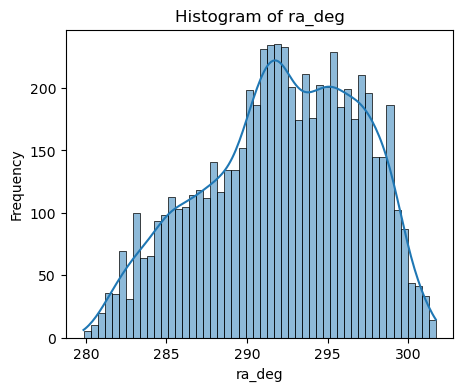

In [168]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "ra_deg", discrete = False, kde = True, bins= 50)
plt.title('Histogram of ra_deg')
plt.xlabel('ra_deg')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [169]:
kepler['ra_deg_log']= np.log(kepler['ra_deg'])

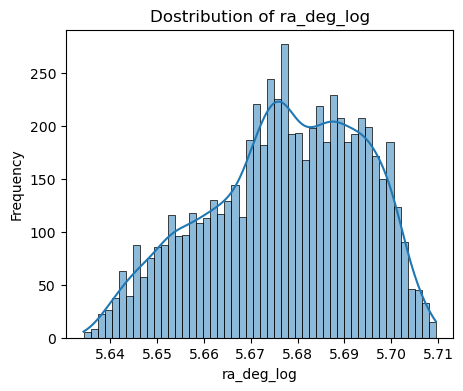

In [170]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "ra_deg_log", discrete = False, kde = True, bins= 50)
plt.title('Dostribution of ra_deg_log')
plt.xlabel('ra_deg_log')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [171]:
kepler['ra_deg_exp']= np.exp(kepler['ra_deg'])

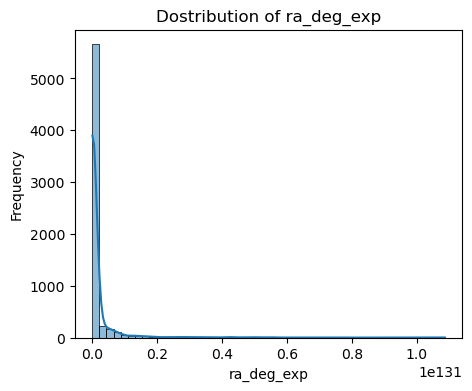

In [172]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "ra_deg_exp", discrete = False, kde = True, bins= 50)
plt.title('Dostribution of ra_deg_exp')
plt.xlabel('ra_deg_exp')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [173]:
kepler['ra_deg'] = np.log(kepler['ra_deg'])
kepler = kepler.drop(['ra_deg_log', 'ra_deg_exp'], axis=1)
kepler.shape

(6442, 42)

##### dec_str

In [174]:
# Extract numeric components from the 'dec_str' column
kepler['dec_day'] = kepler['dec_str'].str.extract(r'([+-]?\d+)d').astype(float)
kepler['dec_min'] = kepler['dec_str'].str.extract(r'(\d+)m').astype(float)
kepler['dec_sec'] = kepler['dec_str'].str.extract(r'(\d+\.\d+)s').astype(float)

In [175]:
# Convert to decimal degrees
kepler['dec_deg'] = kepler['dec_day'] + kepler['dec_min'] / 60 + kepler['dec_sec'] / 3600
kepler['dec_deg']

0       48.141639
1       48.141639
2       48.285222
3       48.226194
4       48.224667
          ...    
6437    47.290722
6438    46.973361
6439    47.093806
6440    47.176278
6441    47.121028
Name: dec_deg, Length: 6442, dtype: float64

In [176]:
# Drop intermediate columns if needed
kepler = kepler.drop(['dec_day', 'dec_min', 'dec_sec'], axis=1)

# Display the DataFrame with the new numeric 'dec_numeric' column
print(kepler[['dec_str', 'dec_deg']])

           dec_str    dec_deg
0     +48d08m29.9s  48.141639
1     +48d08m29.9s  48.141639
2     +48d17m06.8s  48.285222
3     +48d13m34.3s  48.226194
4     +48d13m28.8s  48.224667
...            ...        ...
6437  +47d17m26.6s  47.290722
6438  +46d58m24.1s  46.973361
6439  +47d05m37.7s  47.093806
6440  +47d10m34.6s  47.176278
6441  +47d07m15.7s  47.121028

[6442 rows x 2 columns]


In [177]:
# Droping the 'dec_str' column
kepler = kepler.drop(['dec_str'],1).reset_index(drop=True)
kepler.shape

(6442, 42)

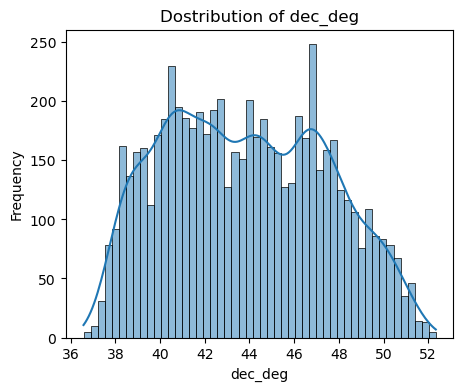

In [178]:
plt.figure(figsize=(5,4))
sns.histplot(data = kepler, x = "dec_deg", discrete = False, kde = True, bins= 50)
plt.title('Dostribution of dec_deg')
plt.xlabel('dec_deg')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [179]:
pd.set_option('display.max_columns', None)
# Display the first 5 rows of the DataFrame
kepler.sample(10)

koi_disposition  koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  \
4753  FALSE POSITIVE      0.000              1              0              1   
1237       CONFIRMED      1.000              0              0              0   
4728  FALSE POSITIVE      0.935              0              1              0   
5047  FALSE POSITIVE      0.001              0              1              0   
1735       CONFIRMED      0.919              0              0              0   
5093  FALSE POSITIVE      0.000              1              0              1   
3616  FALSE POSITIVE      0.000              0              1              1   
1452       CONFIRMED      1.000              0              0              0   
1351       CONFIRMED      1.000              0              0              0   
6083  FALSE POSITIVE      0.000              0              1              0   

      koi_fpflag_ec  koi_period  koi_period_err1  koi_period_err2  \
4753              0    4.291310        -5.046314         0.993588   
1237              0    1.540820       -11.213562         0.999987   
4728              0    0.048147       -11.608006         0.999991   
5047              0    0.732519       -16.328817         1.000000   
1735              0    3.232838        -7.454554         0.999421   
5093              0    3.648175        -5.307762         0.995059   
3616              0    2.243523       -10.965382         0.999983   
1452              0    1.347299       -11.788943         0.999992   
1351              0    2.880845        -8.827803         0.999853   
6083              0    2.039145       -14.012743         0.999999   

      koi_time0bk  koi_time0bk_err1  koi_time0bk_err2  koi_impact  \
4753     6.155342         -3.648224          0.991843   -0.022246   
1237     4.910478         -4.343072          0.997862   -0.238257   
4728     4.884836         -3.659970          0.992012   -0.313342   
5047     4.891167         -5.922700          0.999969   -1.439695   
1735     4.924847         -3.955027          0.995361   -0.936493   
5093     5.287589         -2.689037          0.961943   -0.418550   
3616     4.907319         -4.656209          0.998921    0.238229   
1452     4.889232         -4.518223          0.998531   -2.937463   
1351     5.034702         -4.108585          0.996556   -2.551046   
6083     4.921209         -5.701692          0.999935   -1.010601   

      koi_impact_err1  koi_impact_err2  koi_duration  koi_duration_err1  \
4753        -0.225647         0.974335      2.795817          -0.606969   
1237        -2.063568         0.567225      0.935387          -2.656407   
4728        -1.523260         0.618783      1.578566          -1.171183   
5047        -3.611918         0.988072      1.207380          -5.907123   
1735        -2.673649         0.675704      1.708740          -1.650260   
5093        -1.139434         0.651160      2.224624           0.336472   
3616         1.113172         0.856415      1.741799          -2.828524   
1452        -0.972861         0.948380      0.915210          -3.153556   
1351        -1.067114         0.924964      1.704021          -2.282782   
6083        -5.521461         0.997004      1.789479          -5.629603   

      koi_duration_err2  koi_depth  koi_depth_err1  koi_depth_err2  koi_prad  \
4753           0.579842   6.837118        3.374169    2.082577e-13  2.604170   
1237           0.932207   6.473891        3.126761    1.253389e-10  0.698135   
4728           0.733447   3.091042        0.262364    2.725318e-01 -0.174353   
5047           0.997284  12.483178        4.465908    1.645811e-38  4.192680   
1735           0.825307   5.982424        3.178054    3.775135e-11  0.722706   
5093           0.246597   5.233779        2.850707    3.066941e-08  1.324419   
3616           0.942613   8.796142        4.265493    1.197382e-31  3.472277   
1452           0.958199   5.881929        2.079442    3.354626e-04  0.488580   
1351           0.903030   6.475741        3.025291    1.13

In [180]:
# Print the Numeric Columns
numList = list(kepler.select_dtypes(include=['int64', 'float64']).columns)
print(numList)
print("Total number of numeric columns:", len(numList))

['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_kepmag', 'ra_deg', 'dec_deg']
Total number of numeric columns: 41


In [181]:
# Apply the Anderson-Darling Test on each numeric column
for column in numList:
    # Perform the Anderson-Darling test
    result = anderson(kepler[column])
    
    # Print the result
    print(f"\nColumn: {column}")
    print(f"Anderson-Darling Statistic: {result.statistic}")

    # Check if the data follows a normal distribution based on the 5% significance level
    if result.statistic > result.critical_values[2]:
        print("The data does not follow a normal distribution.")
    else:
        print("The data \033[1mfollows a normal distribution\033[0m.")


Column: koi_score
Anderson-Darling Statistic: 1040.358154284424
The data does not follow a normal distribution.

Column: koi_fpflag_nt
Anderson-Darling Statistic: 2313.4889277346992
The data does not follow a normal distribution.

Column: koi_fpflag_ss
Anderson-Darling Statistic: 1355.1157905704786
The data does not follow a normal distribution.

Column: koi_fpflag_co
Anderson-Darling Statistic: 1503.4945264441449
The data does not follow a normal distribution.

Column: koi_fpflag_ec
Anderson-Darling Statistic: 1863.604683984724
The data does not follow a normal distribution.

Column: koi_period
Anderson-Darling Statistic: 14.796027953609155
The data does not follow a normal distribution.

Column: koi_period_err1
Anderson-Darling Statistic: 8.296928007332099
The data does not follow a normal distribution.

Column: koi_period_err2
Anderson-Darling Statistic: 2063.864687906973
The data does not follow a normal distribution.

Column: koi_time0bk
Anderson-Darling Statistic: 828.1138331508

In [182]:
# Apply the Shapiro-Wilk Test on each numeric column
for column in numList:
    # Perform the Shapiro-Wilk test
    stat, p_value = shapiro(kepler[column])
    
    # Print the result
    print(f"\nColumn: {column}")
    print(f"Shapiro-Wilk Statistic: {stat}")
    print(f"P-value: {p_value}")

    # Check if the data follows a normal distribution based on the 5% significance level
    if p_value > 0.05:
        print("The data \033[1mfollows a normal distribution\033[0m.")
    else:
        print("The data does not follow a normal distribution.")


Column: koi_score
Shapiro-Wilk Statistic: 0.6622628569602966
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_fpflag_nt
Shapiro-Wilk Statistic: 0.006987094879150391
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_fpflag_ss
Shapiro-Wilk Statistic: 0.5885525345802307
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_fpflag_co
Shapiro-Wilk Statistic: 0.5500572919845581
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_fpflag_ec
Shapiro-Wilk Statistic: 0.4428582191467285
P-value: 0.0
The data does not follow a normal distribution.

Column: koi_period
Shapiro-Wilk Statistic: 0.9856307506561279
P-value: 4.5135312711325025e-25
The data does not follow a normal distribution.

Column: koi_period_err1
Shapiro-Wilk Statistic: 0.9918330907821655
P-value: 8.012608563598903e-19
The data does not follow a normal distribution.

Column: koi_period_err2
Shapiro-Wilk Statistic: 0.15441298484802246
P-value:

## Label encoding

**koi_disposition**

In [183]:
kepler["koi_disposition"]

0            CONFIRMED
1            CONFIRMED
2       FALSE POSITIVE
3            CONFIRMED
4            CONFIRMED
             ...      
6437    FALSE POSITIVE
6438    FALSE POSITIVE
6439    FALSE POSITIVE
6440    FALSE POSITIVE
6441    FALSE POSITIVE
Name: koi_disposition, Length: 6442, dtype: object

In [184]:
kepler['koi_disposition']=kepler['koi_disposition'].replace({'FALSE POSITIVE': 0, 'CONFIRMED': 1})

In [185]:
print("Missing values in X_train:", kepler.isnull().sum().sum())
print("Infinite values in X_train:", np.isinf(kepler).sum().sum())

Missing values in X_train: 0
Infinite values in X_train: 98


In [186]:
# Replace Infinite Values
kepler.replace([np.inf, -np.inf], np.nan, inplace=True)
#Remove Rows with Infinite Values:
kepler = kepler.replace([np.inf, -np.inf], np.nan).dropna()

In [187]:
kepler.shape

(6377, 42)

## Feature Selection

In [188]:
# Separting dependent and independent values.
X= kepler.drop(['koi_disposition'],axis=1)
Y = kepler['koi_disposition']

In [189]:
# converting X to float.
X = X.apply(np.float64)

In [190]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6377 entries, 0 to 6441
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   koi_score          6377 non-null   float64
 1   koi_fpflag_nt      6377 non-null   float64
 2   koi_fpflag_ss      6377 non-null   float64
 3   koi_fpflag_co      6377 non-null   float64
 4   koi_fpflag_ec      6377 non-null   float64
 5   koi_period         6377 non-null   float64
 6   koi_period_err1    6377 non-null   float64
 7   koi_period_err2    6377 non-null   float64
 8   koi_time0bk        6377 non-null   float64
 9   koi_time0bk_err1   6377 non-null   float64
 10  koi_time0bk_err2   6377 non-null   float64
 11  koi_impact         6377 non-null   float64
 12  koi_impact_err1    6377 non-null   float64
 13  koi_impact_err2    6377 non-null   float64
 14  koi_duration       6377 non-null   float64
 15  koi_duration_err1  6377 non-null   float64
 16  koi_duration_err2  6377 

In [191]:
Y.head(10)

0    1
1    1
2    0
3    1
4    1
5    1
6    1
7    0
8    1
9    1
Name: koi_disposition, dtype: int64

**Create a dataframe to store the score of different models.**

In [192]:
# Define column names
columns = ['Models', 'Accuracy', 'F1 Score']
# Create a dataframe to store the score of different models.
score = pd.DataFrame(columns=columns)

Creating a function to plot the Confusion matrix and ROC curve.

In [193]:
accuracy = 0
F1_score = 0

def evaluate_model(model, X_test, y_test):

    # Calling the global veriables
    global accuracy
    global F1_score
    
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 4)
    print("The accuracy is: ",accuracy,"\n")

    # Print full classification report
    print("Classification Report-\n", classification_report(y_test, y_pred))

    # Print F1 score
    F1_score = round(f1_score(y_test, y_pred)*100, 4)
    print("F1 Score:", F1_score)

    # Define class labels
    class_labels = ['FALSE POSITIVE', 'CONFIRMED']
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix with modified labels
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Get predicted probabilities for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

#### 1. Without feature engineering

In [194]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, test_size=0.20)
X_train_1.shape, X_test_1.shape, y_train_1.shape, y_test_1.shape

((5101, 41), (1276, 41), (5101,), (1276,))

In [195]:
model_1 = LogisticRegression()
model_1.fit(X_train_1, y_train_1)

LogisticRegression()

The accuracy is:  98.5893 

Classification Report-
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.98      0.98      0.98       534

    accuracy                           0.99      1276
   macro avg       0.99      0.99      0.99      1276
weighted avg       0.99      0.99      0.99      1276

F1 Score: 98.3146


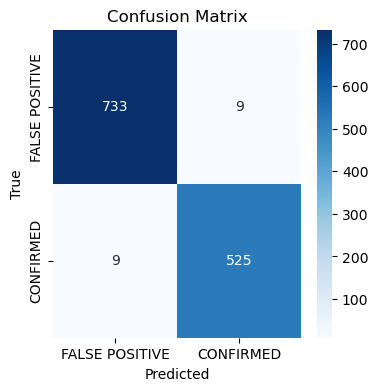

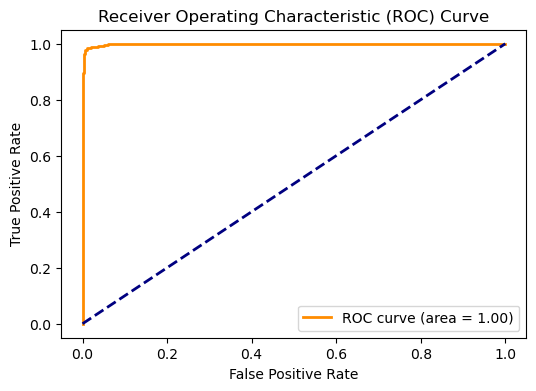

In [196]:
evaluate_model(model_1, X_test_1, y_test_1)

In [197]:
# Add values to the score DataFrame
score.loc[len(score)] = ['Without feature engineering', accuracy, F1_score]

#### 2. Feature Selection Using Logit Regression

In [198]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, test_size=0.20)
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

((5101, 41), (1276, 41), (5101,), (1276,))

In [199]:
# Using Logit regression.
glm = Logit(y_train_2, X_train_2)
res = glm.fit(method='minimize', maxiter=500)

Optimization terminated successfully.
         Current function value: 0.023068
         Iterations: 443
         Function evaluations: 451
         Gradient evaluations: 447


In [200]:
#traing report of Logit regression
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        koi_disposition   No. Observations:                 5101
Model:                          Logit   Df Residuals:                     5060
Method:                           MLE   Df Model:                           40
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.9661
Time:                        12:01:05   Log-Likelihood:                -117.67
converged:                       True   LL-Null:                       -3471.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
koi_score             7.2168      0.652     11.069      0.000       5.939       8.495
koi_fpflag_nt        -0.0108      0.010     -1.098      0.272      -0.030       0.008
koi_fpflag_ss        -7.1395      0.795     -8.984      0.000      -8.697      -5.582
koi_fpflag_co       -21.5607    469.824     -0.046      0.963    -942.398     899.277
koi_fpflag_ec       -11.7278     41.565     -0.282      0.778     -93.194      69.739
koi_period            2.1710      1.524      1.424      0.154      -0.817       5.159
koi_period_err1      -0.5935      0.931     -0.637      0.524      -2.419       1.232
koi_period_err2      -8.0949     72.757     -0.111      0.911    -150.697     134.507
koi_time0bk          -0.1071      0.950     -0.113      0.910      -1.968       1.754
koi_time0bk_err1      0.9377      1.192      0.787      0.431      -1.398       3.273
koi_time0bk_err2    -15.7269      7.651     -2.055      0.040     -30.723      -0.731
koi_impact           -0.2032      0.199     -1.021      0.307      -0.594       0.187
koi_impact_err1       0.1611      0.143      1.129      0.259      -0.119       0.441
koi_impact_err2      -3.3583      1.319     -2.546      0.011      -5.944      -0.773
koi_duration          0.1606      0.711      0.226      0.821      -1.232       1.553
koi_duration_err1     0.5989      0.656      0.914      0.361      -0.686       1.884
koi_duration_err2    13.5389      2.511      5.393      0.000       8.618      18.460
koi_depth            -0.3027      1.042     -0.290      0.772      -2.345       1.740
koi_depth_err1        0.1301      0.986      0.132      0.895      -1.803       2.063
koi_depth_err2       -7.2612      4.916     -1.477      0.140     -16.897       2.375
koi_prad             10.9548      6.437      1.702      0.089      -1.662      23.571
koi_prad_err1       -12.8936      6.454     -1.998      0.046     -25.544      -0.243
koi_prad_err2        -2.0865      2.015     -1.036      0.300      -6.036       1.862
koi_teq              -0.8065     18.428     -0.044      0.965     -36.924      35.311
koi_insol             6.5653      5.068      1.295      0.195      -3.369      16.499
koi_insol_err1       -5.7185      3.441     -1.662      0.097     -12.464       1.027
koi_insol_err2        0.2290      1.352      0.169      0.866      -2.421       2.879
koi_model_snr         1.3223      0.995      1.330      0.184      -0.627       3.272
koi_tce_plnt_num      0.4709      0.230      2.051      0.040       0.021       0.921
koi_steff            -3.9638      4.237     -0.936      0.349     -12.268       4.340
koi_steff_err1       -1.0683      1.440     -0.742      0.458      -3.890       1.754
koi_steff_err2       -0.0068      0.003     -2.119      0.034      -0.013      -0.001
koi_slogg            -0.0959      0.066     -1.443      0.149      -0.226       0.034
koi_slogg_err1       -0.3158      0.596     -0.530      0.596      -1.485       0.853
koi_slogg_err2        7.0246      9.386      0.748      0.4

In [201]:
# Identify predictors with high p-values and drop them
significant_predictors = res.pvalues[res.pvalues < 0.05].index
significant_predictors

Index(['koi_score', 'koi_fpflag_ss', 'koi_time0bk_err2', 'koi_impact_err2',
       'koi_duration_err2', 'koi_prad_err1', 'koi_tce_plnt_num',
       'koi_steff_err2', 'koi_srad', 'koi_srad_err1', 'koi_kepmag', 'dec_deg'],
      dtype='object')

In [202]:
X_train_reduced = X_train_2[significant_predictors]
X_test_reduced = X_test_2[significant_predictors]

In [203]:
X_train_reduced.shape, X_test_reduced.shape, y_train_2.shape, y_test_2.shape

((5101, 12), (1276, 12), (5101,), (1276,))

In [204]:
# Create a logistic regression model
model_2 = LogisticRegression()

In [205]:
# Fit the model using the reduced set of significant predictors
model_2.fit(X_train_reduced, y_train_2)

LogisticRegression()

The accuracy is:  97.8056 

Classification Report-
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       732
           1       0.97      0.98      0.97       544

    accuracy                           0.98      1276
   macro avg       0.98      0.98      0.98      1276
weighted avg       0.98      0.98      0.98      1276

F1 Score: 97.4312


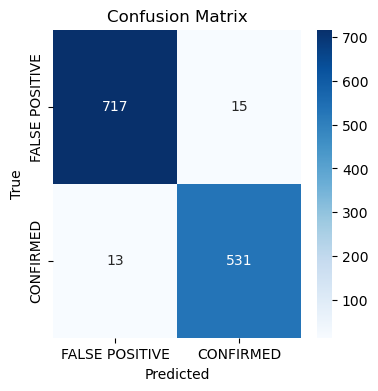

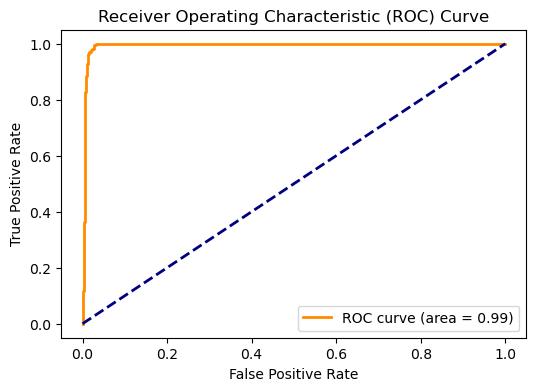

In [206]:
evaluate_model(model_2, X_test_reduced, y_test_2)

In [207]:
score.loc[len(score)] = ['Features Selected using Logit Regression', accuracy, F1_score]

#### 3. Using Pearson Correlation

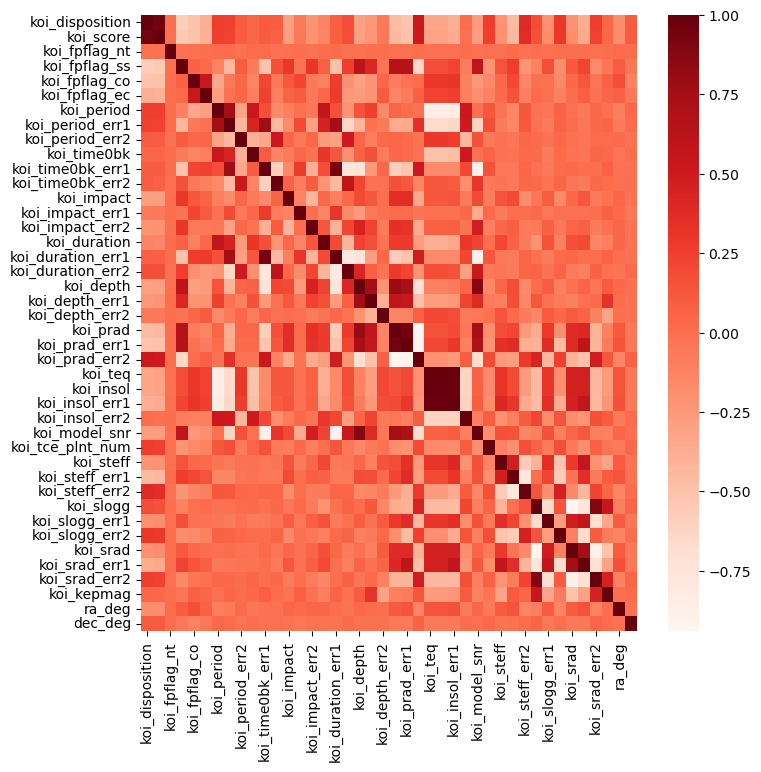

In [208]:
plt.figure(figsize=(8,8))
# Compute the correlation matrix for the DataFrame 'kepler' and store it in the variable 'cor'.
cor = kepler.corr()
# Generate a heatmap of the correlation matrix using seaborn, without annotating each cell, and using the 'Reds' color map.
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
# Display the plot.
plt.show()

In [209]:
# Calculate the absolute correlation between each feature and the target variable 'koi_disposition'.
cor_target = abs(cor["koi_disposition"])
# Select features with a correlation greater than 0.5 with the target variable.
relevant_features = cor_target[cor_target>0.5]
relevant_features

koi_disposition    1.000000
koi_score          0.947584
koi_fpflag_ss      0.577558
koi_fpflag_co      0.511871
koi_prad_err1      0.513195
koi_prad_err2      0.516355
Name: koi_disposition, dtype: float64

In [210]:
# Convert the index of the relevant features to a DataFrame.
relevant_features = pd.DataFrame(relevant_features).index
relevant_features

Index(['koi_disposition', 'koi_score', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_prad_err1', 'koi_prad_err2'],
      dtype='object')

In [211]:
# Create a new DataFrame 'data' containing only the relevant features.
data = kepler[relevant_features]
data

koi_disposition  koi_score  koi_fpflag_ss  koi_fpflag_co  koi_prad_err1  \
0                   1      1.000              0              0      -1.347074   
1                   1      0.969              0              0      -1.139434   
2                   0      0.000              1              0       2.140066   
3                   1      1.000              0              0      -0.127833   
4                   1      1.000              0              0       0.239017   
...               ...        ...            ...            ...            ...   
6437                0      0.008              0              0      -1.309333   
6438                0      0.000              0              0      -1.139434   
6439                0      0.000              1              1       2.041220   
6440                0      0.021              0              1      -1.021651   
6441                0      0.000              0              1      -1.021651   

      koi_prad_err2  
0          0.860708  
1          0.826959  
2          0.059013  
3          0.704688  
4          0.657047  
...             ...  
6437       0.786628  
6438       0.794534  
6439       0.076536  
6440       0.895834  
6441       0.886920  

[6377 rows x 6 columns]

In [212]:
# Separate the features (X) and the target variable (y) from the DataFrame 'data'.
x= data.drop(['koi_disposition'],axis=1)
y = data['koi_disposition']

In [213]:
# Split the data into training and testing sets using a test size of 20%.
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(x, y, test_size=0.20)
# Print the shapes of the training and testing sets.
X_train_3.shape, X_test_3.shape, y_train_3.shape, y_test_3.shape

((5101, 5), (1276, 5), (5101,), (1276,))

In [214]:
model_3 = LogisticRegression()
model_3.fit(X_train_3, y_train_3)

LogisticRegression()

The accuracy is:  98.2759 

Classification Report-
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       764
           1       0.98      0.97      0.98       512

    accuracy                           0.98      1276
   macro avg       0.98      0.98      0.98      1276
weighted avg       0.98      0.98      0.98      1276

F1 Score: 97.8431


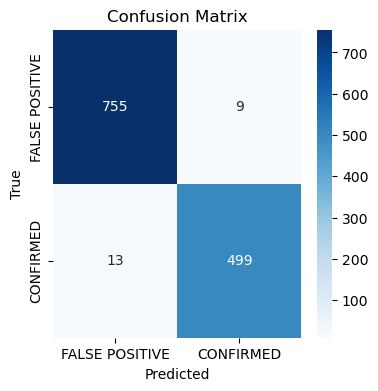

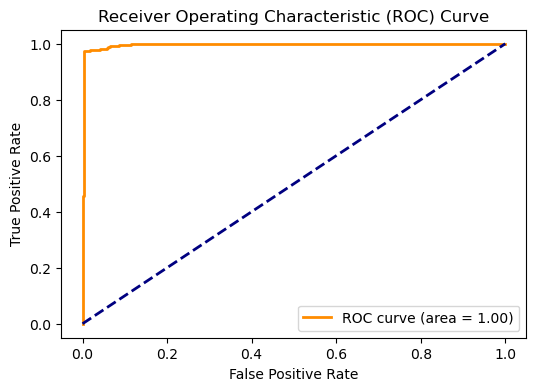

In [215]:
evaluate_model(model_3, X_test_3, y_test_3)

In [216]:
score.loc[len(score)] = ['Using Pearson Correlation', accuracy, F1_score]

#### 4. Using Feature Importance Techniques

In [217]:
# Create a logistic regression model instance.
model_4 = LogisticRegression()
# Fit the logistic regression model to the features 'X' and target variable 'Y'.
model_4.fit(X, Y)

LogisticRegression()

In [218]:
# Extract the coefficients of the logistic regression model.
coefficients = model_4.coef_[0]
# Display the coefficients as a numpy array.
coefficients

array([ 6.06870283e+00, -8.04854231e-03, -2.55660041e+00, -3.41213973e+00,
       -1.99938152e+00,  1.24587068e+00, -1.14311396e-01, -4.60810482e-03,
       -5.20640815e-01, -6.71745222e-01,  4.26395817e-03,  3.07263425e-01,
       -1.26960609e-01, -4.63470220e-01, -4.58306634e-01, -1.59543063e+00,
        7.56305723e-01, -1.80865002e-01,  1.48073605e-01, -9.56081269e-02,
       -1.17039784e+00, -3.94177041e-01,  5.04836461e-01, -2.05190550e-01,
       -3.35120227e-01,  1.15982457e-01, -7.12825585e-01, -6.72021310e-01,
        7.60011593e-01,  7.24195862e-03, -3.32421806e-01,  5.09739349e-03,
       -1.26497943e-02, -2.63680524e-01, -1.22284222e-01, -1.00688907e-01,
        6.66966986e-01,  1.93665286e-01,  2.26561381e-01, -1.41178861e-01,
        1.12549981e-02])

<Axes: ylabel='Feature'>

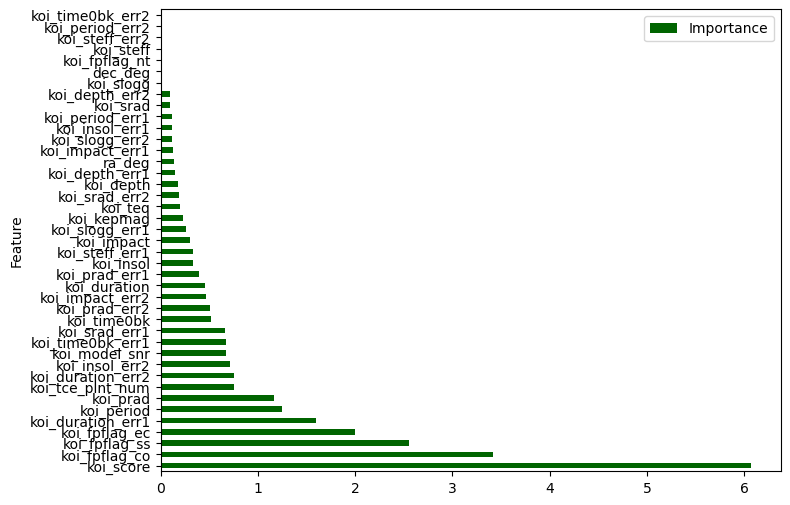

In [219]:
# Create a DataFrame 'feature_importance' with columns 'Feature' and 'Importance' based on the absolute values of the coefficients.
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
# Sort the DataFrame by 'Importance' in descending order.
feature_importance = feature_importance.sort_values('Importance', ascending=False)
# Create a horizontal bar plot of feature importance.
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8, 6), color='darkgreen')

In [220]:
# Select the top k important features.
k = 20
selected_features = feature_importance.head(k)['Feature'].tolist()
selected_features

['koi_score',
 'koi_fpflag_co',
 'koi_fpflag_ss',
 'koi_fpflag_ec',
 'koi_duration_err1',
 'koi_period',
 'koi_prad',
 'koi_tce_plnt_num',
 'koi_duration_err2',
 'koi_insol_err2',
 'koi_model_snr',
 'koi_time0bk_err1',
 'koi_srad_err1',
 'koi_time0bk',
 'koi_prad_err2',
 'koi_impact_err2',
 'koi_duration',
 'koi_prad_err1',
 'koi_insol',
 'koi_steff_err1']

In [221]:
# Create a new DataFrame 'x' containing only the selected features from the original features 'X'.
x= X[selected_features]
# Display the selected features DataFrame.
x

koi_score  koi_fpflag_co  koi_fpflag_ss  koi_fpflag_ec  \
0         1.000            0.0            0.0            0.0   
1         0.969            0.0            0.0            0.0   
2         0.000            0.0            1.0            0.0   
3         1.000            0.0            0.0            0.0   
4         1.000            0.0            0.0            0.0   
...         ...            ...            ...            ...   
6437      0.008            0.0            0.0            0.0   
6438      0.000            0.0            0.0            1.0   
6439      0.000            1.0            1.0            0.0   
6440      0.021            1.0            0.0            0.0   
6441      0.000            1.0            0.0            1.0   

      koi_duration_err1  koi_period  koi_prad  koi_tce_plnt_num  \
0             -2.502256    1.976228  0.815365               1.0   
1             -2.154165    3.186812  1.040277               2.0   
2             -5.226927    0.534539  3.510351               1.0   
3             -3.170086    0.877652  1.011601               1.0   
4             -2.796881    2.095076  1.360977               1.0   
...                 ...         ...       ...               ...   
6437           0.832909    4.262783  0.920283               3.0   
6438          -0.455706    1.899511  0.104360               1.0   
6439          -4.051285   -0.663944  3.379293               1.0   
6440          -1.820159   -0.392413  0.067659               1.0   
6441          -1.262308    1.441703  0.048790               1.0   

      koi_duration_err2  koi_insol_err2  koi_model_snr  koi_time0bk_err1  \
0              0.921364    5.874851e-08       3.577948         -4.338632   
1              0.890475    1.978987e-01       3.250374         -4.098424   
2              0.994644   9.125698e-101       6.225746         -5.518647   
3              0.958870   3.367457e-137       3.711130         -4.636273   
4              0.940823    1.151841e-16       4.197202         -4.537175   
...                 ...             ...            ...               ...   
6437           0.100259    8.958341e-01       2.917771         -2.760213   
6438           0.530466    1.989520e-34       2.128232         -3.268680   
6439           0.982751    0.000000e+00       6.116554         -5.384392   
6440           0.850441    0.000000e+00       2.509599         -4.204014   
6441           0.753520    4.013778e-85       2.104134         -3.490507   

      koi_srad_err1  koi_time0bk  koi_prad_err2  koi_impact_err2  \
0         -2.253795     5.138963       0.860708         0.864158   
1         -2.253795     5.090763       0.826959         0.642107   
2         -1.604450     5.137606       0.059013         0.912105   
3         -1.096614     5.145140       0.704688         0.620022   
4         -1.155183     5.142839       0.657047         0.651811   
...             ...          ...            ...              ...   
6437      -2.603690     5.566422       0.786628         0.517886   
6438      -1.161552     4.882924       0.794534         0.582166   
6439      -1.439695     4.880565       0.076536         0.952181   
6440      -1.075873     4.884178       0.895834         0.863294   
6441      -0.891598     4.912606       0.886920         0.874590   

      koi_duration  koi_prad_err1  koi_insol  koi_steff_err1  
0         1.084344      -1.347074   4.538924        4.394449  
1         1.505632      -1.139434   2.209373        4.394449  
2         0.878136       2.140066   6.793421        5.056246  
3         0.503499      -0.127833   6.831047        5.129899  
4         1.524860       0.239017   4.743279        5.241747  
...            ...            ...        ...             ...  
6437      3.319987      -1.309333  -0.867501        5.056246  
6438      1.569865      -1.139434   5.172754        5.129899  
6439      1.170033       2.041220   8.411950        4.934474  
6440     -0.145026      -1.021651   8.650571        5.262690  
6441     

In [222]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(x, Y, test_size=0.20)
X_train_5.shape, X_test_5.shape, y_train_5.shape, y_test_5.shape

((5101, 20), (1276, 20), (5101,), (1276,))

In [223]:
model_5 = LogisticRegression()
model_5.fit(X_train_5, y_train_5)

LogisticRegression()

The accuracy is:  99.0596 

Classification Report-
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       761
           1       0.99      0.99      0.99       515

    accuracy                           0.99      1276
   macro avg       0.99      0.99      0.99      1276
weighted avg       0.99      0.99      0.99      1276

F1 Score: 98.8372


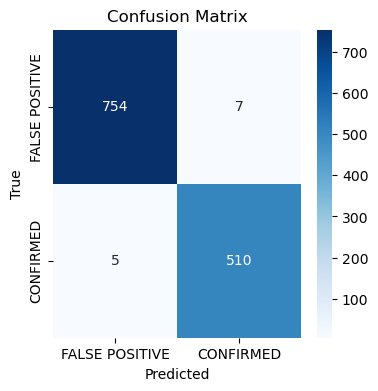

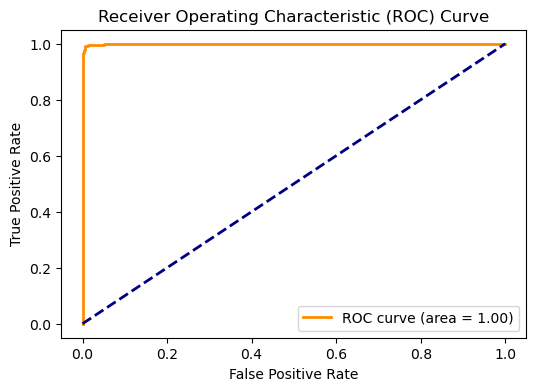

In [224]:
evaluate_model(model_5, X_test_5, y_test_5)

In [225]:
score.loc[len(score)] = ['Using Feature Importance', accuracy, F1_score]

#### 5. Using PCA

In [226]:
# Create a PCA (Principal Component Analysis) model with the goal of retaining 95% of the variance in the original data.
pca = PCA(n_components=0.95, svd_solver='full')   

In [227]:
# Fit the PCA model to the features 'X'.
pca.fit(X)
# Print the explained variance ratio of each principal component.
print(pca.explained_variance_ratio_)
# Print the singular values corresponding to each principal component.
print(pca.singular_values_)
# Transform the original features 'X' using the fitted PCA model and assign the result to the variable 'x'.
x= pca.transform(X)
# Display the shape of the transformed data.
x.shape

[0.91055431 0.07469923]
[6053.27252441 1733.7854902 ]


(6377, 2)

In [228]:
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(x, Y, test_size=0.20)
X_train_6.shape, X_test_6.shape, y_train_6.shape, y_test_6.shape

((5101, 2), (1276, 2), (5101,), (1276,))

In [229]:
#model = DecisionTreeClassifier()
model_6 = LogisticRegression()
model_6.fit(X_train_6, y_train_6)

LogisticRegression()

The accuracy is:  74.6082 

Classification Report-
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       746
           1       0.72      0.65      0.68       530

    accuracy                           0.75      1276
   macro avg       0.74      0.73      0.73      1276
weighted avg       0.74      0.75      0.74      1276

F1 Score: 67.8571


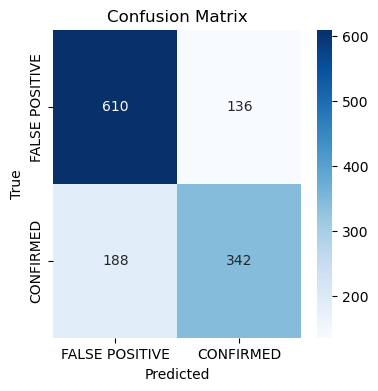

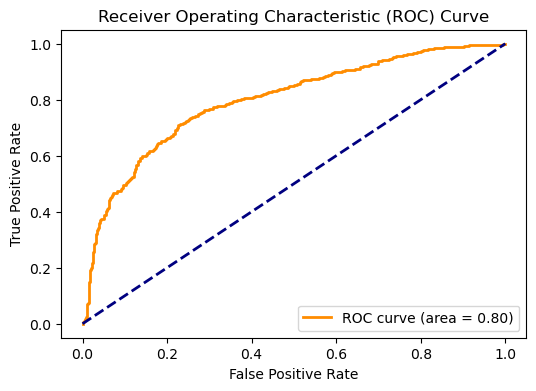

In [230]:
evaluate_model(model_6, X_test_6, y_test_6)

In [231]:
score.loc[len(score)] = ['Using PCA', accuracy, F1_score]

#### 6. Using Chi-Square 

In [232]:
# Compute chi-squared statistics between each feature in 'X' and the target variable 'Y'.
chi_scores = chi2(np.abs(X),Y)
# Display the computed chi-squared scores for each feature.
chi_scores

(array([3.09353454e+03, 8.41286395e+00, 1.44470632e+03, 1.22935991e+03,
        7.52207757e+02, 2.72072842e+02, 2.48869211e+02, 1.47983267e-03,
        1.58249586e-01, 1.06245440e+01, 1.28413473e-02, 6.49083236e+02,
        1.00194345e+02, 1.20413550e+01, 3.76985100e+01, 6.95706065e+01,
        7.76048760e+00, 4.86087636e+02, 2.10331730e+02, 4.35636887e+00,
        2.25129003e+03, 2.97165199e+02, 4.53915937e+02, 4.01402919e+01,
        8.42760881e+02, 1.45305150e+03, 7.50522366e-01, 3.17586854e+02,
        1.53989269e+02, 7.26028576e-01, 3.31369715e+01, 3.43308750e+04,
        1.29719628e+03, 7.53855992e+01, 2.20108332e+00, 1.23226706e+02,
        3.42965722e+02, 2.52485649e+01, 6.54583534e-02, 1.06046928e-02,
        2.34962699e+01]),
 array([0.00000000e+000, 3.72575277e-003, 0.00000000e+000, 2.53883627e-269,
        1.32848499e-165, 4.01003873e-061, 4.58103920e-056, 9.69314072e-001,
        6.90773219e-001, 1.11596482e-003, 9.09777124e-001, 3.53581499e-143,
        1.38153363e-023, 5

In [233]:
# Create a pandas Series containing p-values from the chi-squared test, indexed by the column names of 'X'.
p_values = pd.Series(chi_scores[1],index = X.columns)
# Sort the p-values in descending order, updating the 'p_values' Series in-place.
p_values.sort_values(ascending = False , inplace = True)

<Axes: >

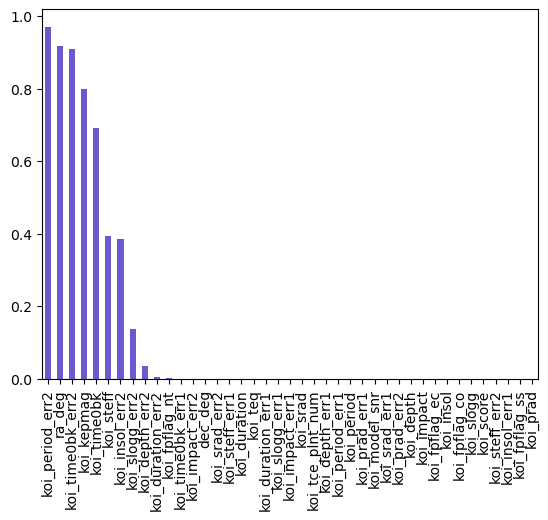

In [234]:
# Create a bar plot of the p-values using the 'plot.bar()' function.
p_values.plot.bar(color='slateblue')

In [235]:
# Create a DataFrame 'featureScores' from the transposed chi-squared scores, with columns representing features and their corresponding scores.
featureScores = pd.DataFrame(chi_scores).T
# Display the DataFrame showing features and their respective chi-squared scores.
featureScores

0              1
0    3093.534536   0.000000e+00
1       8.412864   3.725753e-03
2    1444.706322   0.000000e+00
3    1229.359913  2.538836e-269
4     752.207757  1.328485e-165
5     272.072842   4.010039e-61
6     248.869211   4.581039e-56
7       0.001480   9.693141e-01
8       0.158250   6.907732e-01
9      10.624544   1.115965e-03
10      0.012841   9.097771e-01
11    649.083236  3.535815e-143
12    100.194345   1.381534e-23
13     12.041355   5.203313e-04
14     37.698510   8.256760e-10
15     69.570607   7.372746e-17
16      7.760488   5.340154e-03
17    486.087636  1.011824e-107
18    210.331730   1.162765e-47
19      4.356369   3.687082e-02
20   2251.290029   0.000000e+00
21    297.165199   1.365805e-66
22    453.915937  1.013695e-100
23     40.140292   2.363632e-10
24    842.760881  2.725047e-185
25   1453.051496   0.000000e+00
26      0.750522   3.863109e-01
27    317.586854   4.858954e-71
28    153.989269   2.328488e-35
29      0.726029   3.941735e-01
30     33.136972   8.588995e-09
31  34330.874974   0.000000e+00
32   1297.196276  4.597385e-284
33     75.385599   3.872038e-18
34      2.201083   1.379138e-01
35    123.226706   1.243921e-28
36    342.965722   1.442106e-76
37     25.248565   5.039706e-07
38      0.065458   7.980680e-01
39      0.010605   9.179796e-01
40     23.496270   1.251562e-06

In [236]:
# Rename the columns of the 'featureScores' DataFrame to 'Chi-Scores' and 'p-Value'.
featureScores.columns =['Chi-Scores', 'p-Value']
# Assign the column names of the original features 'X' to a new column 'Features' in the 'featureScores' DataFrame.
featureScores['Features'] = X.columns
# Filter the 'featureScores' DataFrame to include only rows where the 'p-Value' is greater than 0.05.
featureScores = featureScores[featureScores['p-Value']>0.05]
# Display the 'Features' column of the filtered 'featureScores' DataFrame.
featureScores['Features']

7      koi_period_err2
8          koi_time0bk
10    koi_time0bk_err2
26      koi_insol_err2
29           koi_steff
34      koi_slogg_err2
38          koi_kepmag
39              ra_deg
Name: Features, dtype: object

In [237]:
# Extract the 'Features' column from the 'featureScores' DataFrame and convert it to a NumPy array.
bestCols = np.array(featureScores['Features'])
# Display the resulting NumPy array containing the selected features.
bestCols

array(['koi_period_err2', 'koi_time0bk', 'koi_time0bk_err2',
       'koi_insol_err2', 'koi_steff', 'koi_slogg_err2', 'koi_kepmag',
       'ra_deg'], dtype=object)

In [238]:
# Create a new DataFrame 'x' containing only the selected features from the original features 'X' based on 'bestCols'.
x=X[bestCols]
# Display the resulting DataFrame with the selected features.
x

koi_period_err2  koi_time0bk  koi_time0bk_err2  koi_insol_err2  \
0            0.999972     5.138963          0.997842    5.874851e-08   
1            0.999752     5.090763          0.996486    1.978987e-01   
2            1.000000     5.137606          0.999885   9.125698e-101   
3            0.999996     5.145140          0.998871   3.367457e-137   
4            0.999980     5.142839          0.998591    1.151841e-16   
...               ...          ...               ...             ...   
6437         0.983527     5.566422          0.965702    8.958341e-01   
6438         0.999815     4.882924          0.984423    1.989520e-34   
6439         1.000000     4.880565          0.999830    0.000000e+00   
6440         0.999998     4.884178          0.997154    0.000000e+00   
6441         0.999936     4.912606          0.989258    4.013778e-85   

      koi_steff  koi_slogg_err2  koi_kepmag    ra_deg  
0      8.604288        0.908464    2.730920  5.676529  
1      8.604288        0.908464    2.730920  5.676529  
2      8.666475        0.845354    2.747079  5.654363  
3      8.704668        0.810584    2.741421  5.665578  
4      8.707152        0.795329    2.754552  5.691326  
...         ...             ...         ...       ...  
6437   8.568456        0.949329    2.702099  5.673103  
6438   8.637285        0.827787    2.672630  5.699604  
6439   8.637285        0.822012    2.644897  5.694367  
6440   8.727940        0.799315    2.733393  5.684140  
6441   8.774777        0.805735    2.696382  5.693765  

[6377 rows x 8 columns]

In [239]:
# Split the selected features 'x' and the target variable 'Y' into training and testing sets using a test size of 20%.
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(x, Y, test_size=0.20)
# Display the shapes of the resulting training and testing sets.
X_train_7.shape, X_test_7.shape, y_train_7.shape, y_test_7.shape

((5101, 8), (1276, 8), (5101,), (1276,))

In [240]:
model_7 = LogisticRegression()
model_7.fit(X_train_7, y_train_7)

LogisticRegression()

The accuracy is:  64.4984 

Classification Report-
               precision    recall  f1-score   support

           0       0.66      0.81      0.73       750
           1       0.60      0.41      0.49       526

    accuracy                           0.64      1276
   macro avg       0.63      0.61      0.61      1276
weighted avg       0.64      0.64      0.63      1276

F1 Score: 48.5812


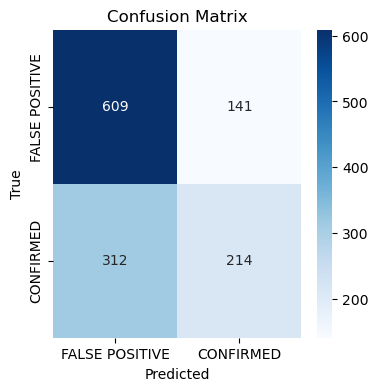

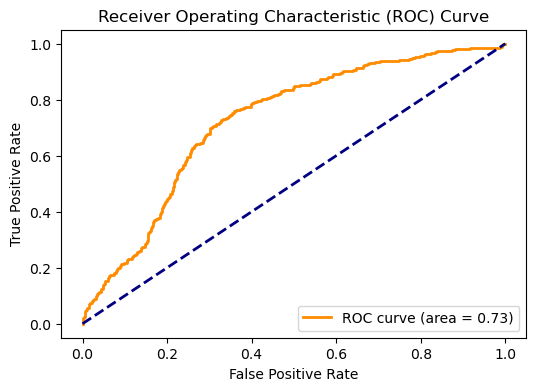

In [241]:
evaluate_model(model_7, X_test_7, y_test_7)

In [242]:
score.loc[len(score)] = ['Using Chi-Square', accuracy, F1_score]

In [243]:
score = score.sort_values(by='Accuracy', ascending=False)
score

Models  Accuracy  F1 Score
3                  Using Feature Importance   99.0596   98.8372
0               Without feature engineering   98.5893   98.3146
2                 Using Pearson Correlation   98.2759   97.8431
1  Features Selected using Logit Regression   97.8056   97.4312
4                                 Using PCA   74.6082   67.8571
5                          Using Chi-Square   64.4984   48.5812

## Model Preparation

As the features selected Using Feature Importance have high score hence we are using features selected using that as final features for the models.

In [244]:
# Create a new DataFrame 'x' containing only the selected features from the original features 'X'.
x= X[selected_features]
# Display the resulting DataFrame with the selected features.
x

koi_score  koi_fpflag_co  koi_fpflag_ss  koi_fpflag_ec  \
0         1.000            0.0            0.0            0.0   
1         0.969            0.0            0.0            0.0   
2         0.000            0.0            1.0            0.0   
3         1.000            0.0            0.0            0.0   
4         1.000            0.0            0.0            0.0   
...         ...            ...            ...            ...   
6437      0.008            0.0            0.0            0.0   
6438      0.000            0.0            0.0            1.0   
6439      0.000            1.0            1.0            0.0   
6440      0.021            1.0            0.0            0.0   
6441      0.000            1.0            0.0            1.0   

      koi_duration_err1  koi_period  koi_prad  koi_tce_plnt_num  \
0             -2.502256    1.976228  0.815365               1.0   
1             -2.154165    3.186812  1.040277               2.0   
2             -5.226927    0.534539  3.510351               1.0   
3             -3.170086    0.877652  1.011601               1.0   
4             -2.796881    2.095076  1.360977               1.0   
...                 ...         ...       ...               ...   
6437           0.832909    4.262783  0.920283               3.0   
6438          -0.455706    1.899511  0.104360               1.0   
6439          -4.051285   -0.663944  3.379293               1.0   
6440          -1.820159   -0.392413  0.067659               1.0   
6441          -1.262308    1.441703  0.048790               1.0   

      koi_duration_err2  koi_insol_err2  koi_model_snr  koi_time0bk_err1  \
0              0.921364    5.874851e-08       3.577948         -4.338632   
1              0.890475    1.978987e-01       3.250374         -4.098424   
2              0.994644   9.125698e-101       6.225746         -5.518647   
3              0.958870   3.367457e-137       3.711130         -4.636273   
4              0.940823    1.151841e-16       4.197202         -4.537175   
...                 ...             ...            ...               ...   
6437           0.100259    8.958341e-01       2.917771         -2.760213   
6438           0.530466    1.989520e-34       2.128232         -3.268680   
6439           0.982751    0.000000e+00       6.116554         -5.384392   
6440           0.850441    0.000000e+00       2.509599         -4.204014   
6441           0.753520    4.013778e-85       2.104134         -3.490507   

      koi_srad_err1  koi_time0bk  koi_prad_err2  koi_impact_err2  \
0         -2.253795     5.138963       0.860708         0.864158   
1         -2.253795     5.090763       0.826959         0.642107   
2         -1.604450     5.137606       0.059013         0.912105   
3         -1.096614     5.145140       0.704688         0.620022   
4         -1.155183     5.142839       0.657047         0.651811   
...             ...          ...            ...              ...   
6437      -2.603690     5.566422       0.786628         0.517886   
6438      -1.161552     4.882924       0.794534         0.582166   
6439      -1.439695     4.880565       0.076536         0.952181   
6440      -1.075873     4.884178       0.895834         0.863294   
6441      -0.891598     4.912606       0.886920         0.874590   

      koi_duration  koi_prad_err1  koi_insol  koi_steff_err1  
0         1.084344      -1.347074   4.538924        4.394449  
1         1.505632      -1.139434   2.209373        4.394449  
2         0.878136       2.140066   6.793421        5.056246  
3         0.503499      -0.127833   6.831047        5.129899  
4         1.524860       0.239017   4.743279        5.241747  
...            ...            ...        ...             ...  
6437      3.319987      -1.309333  -0.867501        5.056246  
6438      1.569865      -1.139434   5.172754        5.129899  
6439      1.170033       2.041220   8.411950        4.934474  
6440     -0.145026      -1.021651   8.650571        5.262690  
6441     

In [245]:
# Split the selected features 'x' and the target variable 'Y' into training and testing sets using a test size of 20%.
X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size=0.20)
# Display the shapes of the resulting training and testing sets.
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5101, 20), (1276, 20), (5101,), (1276,))

In [246]:
# Display the shapes of the training feature set (X_train), testing feature set (X_test),
# training target variable (y_train), and testing target variable (y_test).
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5101, 20), (1276, 20), (5101,), (1276,))

In [247]:
# Define column names
columns = ['Models', 'Accuracy']
modelScores = pd.DataFrame(columns=columns)

## XGBoost

XGBoost is used when: 
- There are a large number of observations in training data
- The number of features is less than the number of observations in training data
- The data has a mixture of numerical and categorical features

Model performance metrics are being considered

In [248]:
# Create an XGBoost classifier model with a specified random state (369).
xgb = XGBClassifier(random_state=369)

In [249]:
# Train (fit) the XGBoost classifier model on the training data (X_train and y_train).
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=369, ...)

In [250]:
# Use the trained XGBoost classifier model to make predictions on the testing data (X_test).
pred_XGB = xgb.predict(X_test)

In [251]:
# Calculate the accuracy of the XGBoost classifier predictions on the testing data with three decimal places.
accuracyXGB= np.round(accuracy_score(y_test, pred_XGB)*100,5)
print("Accuracy = ", accuracyXGB)

Accuracy =  98.98119


In [252]:
# Calculate the weighted F1 score of the XGBoost classifier predictions on the testing data.
f1= np.round(f1_score(y_test, pred_XGB, average ='weighted')*100,2)
print("F1 = ", f1)

F1 =  98.98


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       743
           1       0.99      0.99      0.99       533

    accuracy                           0.99      1276
   macro avg       0.99      0.99      0.99      1276
weighted avg       0.99      0.99      0.99      1276



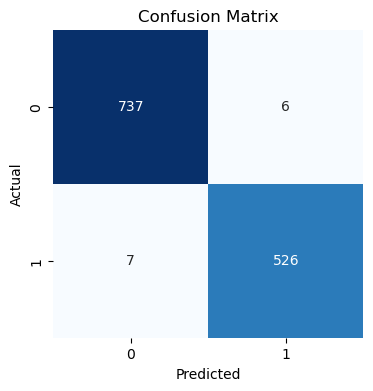

In [253]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, pred_XGB))

# Plot Confusion Matrix
conf_mat = confusion_matrix(y_test, pred_XGB)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [254]:
modelScores.loc[len(score)] = ['XGBoost', accuracyXGB]

## CatBoost Classifier

CatBoost uses a combination of: 
- Ordered boosting
- Random permutations
- Gradient-based optimization

CatBoost is different from XGBoost and LightGBM because it builds symmetric trees. In every step, leaves from the previous tree are split using the same condition. 

In [255]:
# Create an instance of the CatBoostClassifier with default hyperparameters
cat = CatBoostClassifier()

In [256]:
# Train the CatBoostClassifier on the training data
cat.fit(X_train, y_train)

Learning rate set to 0.020659
0:	learn: 0.6462532	total: 186ms	remaining: 3m 6s
1:	learn: 0.5996412	total: 199ms	remaining: 1m 39s
2:	learn: 0.5637966	total: 211ms	remaining: 1m 10s
3:	learn: 0.5187772	total: 224ms	remaining: 55.7s
4:	learn: 0.4858561	total: 234ms	remaining: 46.5s
5:	learn: 0.4481513	total: 242ms	remaining: 40.1s
6:	learn: 0.4151694	total: 250ms	remaining: 35.4s
7:	learn: 0.3875122	total: 255ms	remaining: 31.7s
8:	learn: 0.3566081	total: 263ms	remaining: 28.9s
9:	learn: 0.3297559	total: 268ms	remaining: 26.5s
10:	learn: 0.3109501	total: 273ms	remaining: 24.6s
11:	learn: 0.2885121	total: 280ms	remaining: 23s
12:	learn: 0.2665888	total: 285ms	remaining: 21.6s
13:	learn: 0.2510966	total: 290ms	remaining: 20.4s
14:	learn: 0.2333119	total: 294ms	remaining: 19.3s
15:	learn: 0.2165394	total: 298ms	remaining: 18.3s
16:	learn: 0.2018615	total: 303ms	remaining: 17.5s
17:	learn: 0.1884861	total: 306ms	remaining: 16.7s
18:	learn: 0.1764877	total: 310ms	remaining: 16s
19:	learn: 0.

179:	learn: 0.0155711	total: 980ms	remaining: 4.46s
180:	learn: 0.0155469	total: 984ms	remaining: 4.45s
181:	learn: 0.0155288	total: 988ms	remaining: 4.44s
182:	learn: 0.0154660	total: 992ms	remaining: 4.43s
183:	learn: 0.0153985	total: 997ms	remaining: 4.42s
184:	learn: 0.0153533	total: 1s	remaining: 4.41s
185:	learn: 0.0152798	total: 1s	remaining: 4.4s
186:	learn: 0.0152178	total: 1.01s	remaining: 4.39s
187:	learn: 0.0151654	total: 1.01s	remaining: 4.38s
188:	learn: 0.0151368	total: 1.02s	remaining: 4.37s
189:	learn: 0.0151080	total: 1.02s	remaining: 4.36s
190:	learn: 0.0150870	total: 1.03s	remaining: 4.35s
191:	learn: 0.0150308	total: 1.03s	remaining: 4.34s
192:	learn: 0.0149776	total: 1.04s	remaining: 4.33s
193:	learn: 0.0149341	total: 1.04s	remaining: 4.32s
194:	learn: 0.0148708	total: 1.04s	remaining: 4.31s
195:	learn: 0.0148458	total: 1.05s	remaining: 4.3s
196:	learn: 0.0147978	total: 1.05s	remaining: 4.29s
197:	learn: 0.0147781	total: 1.06s	remaining: 4.28s
198:	learn: 0.014731

391:	learn: 0.0092317	total: 1.77s	remaining: 2.75s
392:	learn: 0.0092258	total: 1.78s	remaining: 2.74s
393:	learn: 0.0092131	total: 1.78s	remaining: 2.74s
394:	learn: 0.0091642	total: 1.78s	remaining: 2.73s
395:	learn: 0.0091584	total: 1.79s	remaining: 2.72s
396:	learn: 0.0091357	total: 1.79s	remaining: 2.72s
397:	learn: 0.0091080	total: 1.79s	remaining: 2.71s
398:	learn: 0.0090873	total: 1.8s	remaining: 2.71s
399:	learn: 0.0090661	total: 1.8s	remaining: 2.7s
400:	learn: 0.0090493	total: 1.81s	remaining: 2.7s
401:	learn: 0.0090337	total: 1.81s	remaining: 2.69s
402:	learn: 0.0090139	total: 1.81s	remaining: 2.69s
403:	learn: 0.0090003	total: 1.82s	remaining: 2.68s
404:	learn: 0.0089843	total: 1.82s	remaining: 2.68s
405:	learn: 0.0089735	total: 1.83s	remaining: 2.67s
406:	learn: 0.0089620	total: 1.83s	remaining: 2.67s
407:	learn: 0.0089543	total: 1.83s	remaining: 2.66s
408:	learn: 0.0089466	total: 1.84s	remaining: 2.66s
409:	learn: 0.0089156	total: 1.84s	remaining: 2.65s
410:	learn: 0.00

578:	learn: 0.0068835	total: 2.56s	remaining: 1.86s
579:	learn: 0.0068689	total: 2.57s	remaining: 1.86s
580:	learn: 0.0068595	total: 2.57s	remaining: 1.86s
581:	learn: 0.0068558	total: 2.58s	remaining: 1.85s
582:	learn: 0.0068513	total: 2.58s	remaining: 1.85s
583:	learn: 0.0068316	total: 2.59s	remaining: 1.84s
584:	learn: 0.0068289	total: 2.59s	remaining: 1.84s
585:	learn: 0.0068092	total: 2.6s	remaining: 1.83s
586:	learn: 0.0068063	total: 2.6s	remaining: 1.83s
587:	learn: 0.0067950	total: 2.61s	remaining: 1.83s
588:	learn: 0.0067844	total: 2.61s	remaining: 1.82s
589:	learn: 0.0067719	total: 2.62s	remaining: 1.82s
590:	learn: 0.0067572	total: 2.62s	remaining: 1.81s
591:	learn: 0.0067446	total: 2.62s	remaining: 1.81s
592:	learn: 0.0067388	total: 2.63s	remaining: 1.8s
593:	learn: 0.0067257	total: 2.63s	remaining: 1.8s
594:	learn: 0.0067224	total: 2.64s	remaining: 1.79s
595:	learn: 0.0067102	total: 2.64s	remaining: 1.79s
596:	learn: 0.0067007	total: 2.65s	remaining: 1.79s
597:	learn: 0.00

760:	learn: 0.0053526	total: 3.35s	remaining: 1.05s
761:	learn: 0.0053449	total: 3.36s	remaining: 1.05s
762:	learn: 0.0053374	total: 3.36s	remaining: 1.04s
763:	learn: 0.0053374	total: 3.37s	remaining: 1.04s
764:	learn: 0.0053374	total: 3.37s	remaining: 1.03s
765:	learn: 0.0053365	total: 3.38s	remaining: 1.03s
766:	learn: 0.0053191	total: 3.38s	remaining: 1.03s
767:	learn: 0.0053109	total: 3.38s	remaining: 1.02s
768:	learn: 0.0053092	total: 3.39s	remaining: 1.02s
769:	learn: 0.0052893	total: 3.39s	remaining: 1.01s
770:	learn: 0.0052825	total: 3.4s	remaining: 1.01s
771:	learn: 0.0052752	total: 3.4s	remaining: 1s
772:	learn: 0.0052584	total: 3.41s	remaining: 1s
773:	learn: 0.0052536	total: 3.41s	remaining: 996ms
774:	learn: 0.0052355	total: 3.42s	remaining: 992ms
775:	learn: 0.0052308	total: 3.42s	remaining: 987ms
776:	learn: 0.0052308	total: 3.42s	remaining: 983ms
777:	learn: 0.0052241	total: 3.43s	remaining: 978ms
778:	learn: 0.0052210	total: 3.43s	remaining: 974ms
779:	learn: 0.005209

941:	learn: 0.0042745	total: 4.13s	remaining: 255ms
942:	learn: 0.0042714	total: 4.14s	remaining: 250ms
943:	learn: 0.0042600	total: 4.14s	remaining: 246ms
944:	learn: 0.0042565	total: 4.15s	remaining: 241ms
945:	learn: 0.0042565	total: 4.15s	remaining: 237ms
946:	learn: 0.0042530	total: 4.16s	remaining: 233ms
947:	learn: 0.0042454	total: 4.16s	remaining: 228ms
948:	learn: 0.0042385	total: 4.17s	remaining: 224ms
949:	learn: 0.0042368	total: 4.17s	remaining: 220ms
950:	learn: 0.0042356	total: 4.17s	remaining: 215ms
951:	learn: 0.0042356	total: 4.18s	remaining: 211ms
952:	learn: 0.0042309	total: 4.18s	remaining: 206ms
953:	learn: 0.0042297	total: 4.19s	remaining: 202ms
954:	learn: 0.0042226	total: 4.19s	remaining: 198ms
955:	learn: 0.0042172	total: 4.2s	remaining: 193ms
956:	learn: 0.0042161	total: 4.2s	remaining: 189ms
957:	learn: 0.0042126	total: 4.21s	remaining: 184ms
958:	learn: 0.0042069	total: 4.21s	remaining: 180ms
959:	learn: 0.0042030	total: 4.21s	remaining: 176ms
960:	learn: 0.

In [257]:
# make predictions on the test data
pred_Cat = cat.predict(X_test)

In [258]:
# Calculate the accuracy on the test data
accuracyCat= np.round(accuracy_score(y_test, pred_Cat)*100,5)
print("Accuracy = ", accuracyCat)

Accuracy =  99.2163


In [259]:
# Calculate the weighted F1 score of the CatBoost classifier predictions on the testing data with three decimal places.
f1= np.round(f1_score(y_test, pred_Cat, average='weighted')*100,2)
print("F1 = ", f1)

F1 =  99.22


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       743
           1       0.99      0.99      0.99       533

    accuracy                           0.99      1276
   macro avg       0.99      0.99      0.99      1276
weighted avg       0.99      0.99      0.99      1276



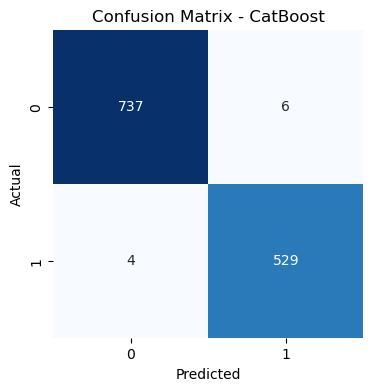

In [260]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, pred_Cat))

# Plot Confusion Matrix
conf_mat_cat = confusion_matrix(y_test, pred_Cat)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_mat_cat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CatBoost')
plt.show()

In [261]:
modelScores.loc[len(modelScores)] = ['CatBoost', accuracyCat]

## Variational Encoder

Reshaping the X_train and X_test as the deep leaning models work on 3 dimentional data.

In [262]:
# Convert the training data 'X_train' to a NumPy array and reshape it
X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)

In [263]:
# Convert the training data 'X_test' to a NumPy array and reshape it
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

In [264]:
X_train.shape, X_test.shape

((5101, 20, 1), (1276, 20, 1))

In [265]:
# Set the random seed for reproducibility in Keras
keras.utils.set_random_seed(0)

In [266]:
# Defining the input layer for the encoder with the shape of the input data
encoder_inputs = keras.Input(shape=(X_test.shape[1],1))
# Creating the first SimpleRNN layer with 512 units and set to return sequences
# This layer processes input sequences and produces output sequences with the same length
encoder = layers.SimpleRNN(512, return_sequences=True)(encoder_inputs)
# Creating a second SimpleRNN layer with 128 units and set to return sequences
encoder = layers.SimpleRNN(128, return_sequences=True)(encoder)
# Creating a third SimpleRNN layer with 64 units
# This layer does not return sequences, indicating it's the final encoding layer
encoder = layers.SimpleRNN(64)(encoder)

In [267]:
# Creating a Dense layer with 64 units and sigmoid activation function for the output layer
output = layers.Dense(units=64, activation='sigmoid')(encoder)
# Adding a Dropout layer with a dropout rate of 20% to prevent overfitting
output = layers.Dropout(.2)(output)
# Creating a Dense layer with 4 units and sigmoid activation function for the decoder output
decoder = layers.Dense(units=4, activation='sigmoid')(output)

In [268]:
# Create a Keras Model named 'var' with specified input and output layers
var = keras.Model(encoder_inputs, decoder, name="VAR")
# Compile the 'var' model with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as a metric
var.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
var.summary()

Model: "VAR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 512)           263168    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 128)           82048     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260     

In [269]:
# training the model for 10 epochs and checing for validation score for a subset of traing data
#Validation split helps to improve the model performance by fine-tuning the model after each epoch. 
#The test set informs us about the final accuracy of the model after completing the training phase. 
history = var.fit(X_train, y_train, epochs = 10, validation_split=0.20)

Epoch 1/10
128/128 [==============================] - 8s 46ms/step - loss: 0.2328 - accuracy: 0.9289 - val_loss: 0.0907 - val_accuracy: 0.9775
Epoch 2/10
128/128 [==============================] - 6s 44ms/step - loss: 0.1105 - accuracy: 0.9725 - val_loss: 0.1093 - val_accuracy: 0.9745
Epoch 3/10
128/128 [==============================] - 6s 43ms/step - loss: 0.1334 - accuracy: 0.9689 - val_loss: 0.1059 - val_accuracy: 0.9785
Epoch 4/10
128/128 [==============================] - 5s 43ms/step - loss: 0.2477 - accuracy: 0.9167 - val_loss: 0.1086 - val_accuracy: 0.9716
Epoch 5/10
128/128 [==============================] - 5s 41ms/step - loss: 0.1677 - accuracy: 0.9547 - val_loss: 0.1160 - val_accuracy: 0.9745
Epoch 6/10
128/128 [==============================] - 5s 43ms/step - loss: 0.1318 - accuracy: 0.9716 - val_loss: 0.1086 - val_accuracy: 0.9755
Epoch 7/10
128/128 [==============================] - 5s 42ms/step - loss: 0.1799 - accuracy: 0.9473 - val_loss: 0.1341 - val_accuracy: 0.9716

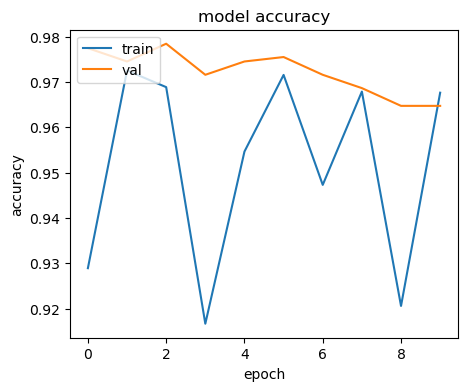

In [270]:
plt.figure(figsize=(5,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

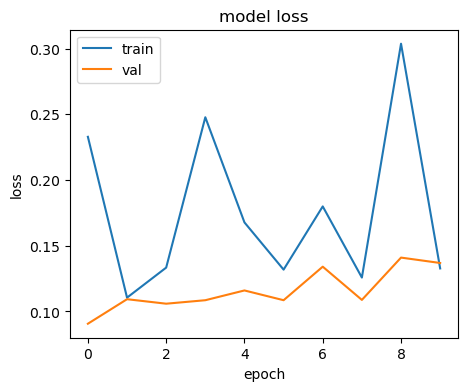

In [271]:
# Plot Loss vs Epoch
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [272]:
# Evaluate the 'var' model on the test data and retrieve the loss and accuracy
loss, accuracyVAR=var.evaluate(X_test, y_test)
accuracyVAR= np.round(accuracyVAR * 100,5)
print("Accuracy: %.2f%%" % (accuracyVAR))

40/40 [==============================] - 1s 20ms/step - loss: 0.1146 - accuracy: 0.9718
Accuracy: 97.18%


In [274]:
# Predict on the test set
y_pred = var.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

40/40 [==============================] - 1s 15ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       743
           1       0.95      0.98      0.97       533

    accuracy                           0.97      1276
   macro avg       0.97      0.97      0.97      1276
weighted avg       0.97      0.97      0.97      1276



In [275]:
modelScores.loc[len(modelScores)] = ['Variational Encoder', accuracyVAR]

## RNN

In [276]:
# Set the random seed for reproducibility in Keras
keras.utils.set_random_seed(0)

In [277]:
# Create a sequential model 'rnn' using Keras
rnn = keras.Sequential([
    # Add a SimpleRNN layer with 32 units and specify the input shape
    layers.SimpleRNN(32, input_shape=(X_test.shape[1], 1)),
    # Add a Dense layer with 10 units and ReLU activation function
    layers.Dense(10, activation='relu'),
    # Add a Dense layer with 4 units and sigmoid activation function
    layers.Dense(4, activation='sigmoid')
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1462 (5.71 KB)
Trainable params: 1462 (5.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [278]:
# Compile the 'rnn' model with specified loss function and metrics
rnn.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1462 (5.71 KB)
Trainable params: 1462 (5.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [279]:
# Train the 'rnn' model on the training data with 10 epochs and 20% validation split
history = rnn.fit(X_train, y_train, epochs = 10, validation_split=0.20)

Epoch 1/10
128/128 [==============================] - 2s 6ms/step - loss: 0.6612 - accuracy: 0.7615 - val_loss: 0.1954 - val_accuracy: 0.9452
Epoch 2/10
128/128 [==============================] - 0s 4ms/step - loss: 0.1112 - accuracy: 0.9672 - val_loss: 0.0740 - val_accuracy: 0.9814
Epoch 3/10
128/128 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.9804 - val_loss: 0.0509 - val_accuracy: 0.9873
Epoch 4/10
128/128 [==============================] - 0s 4ms/step - loss: 0.0633 - accuracy: 0.9819 - val_loss: 0.0497 - val_accuracy: 0.9873
Epoch 5/10
128/128 [==============================] - 0s 4ms/step - loss: 0.0573 - accuracy: 0.9824 - val_loss: 0.0614 - val_accuracy: 0.9804
Epoch 6/10
128/128 [==============================] - 0s 4ms/step - loss: 0.0585 - accuracy: 0.9809 - val_loss: 0.0401 - val_accuracy: 0.9863
Epoch 7/10
128/128 [==============================] - 0s 4ms/step - loss: 0.0552 - accuracy: 0.9828 - val_loss: 0.0469 - val_accuracy: 0.9824
Epoch 

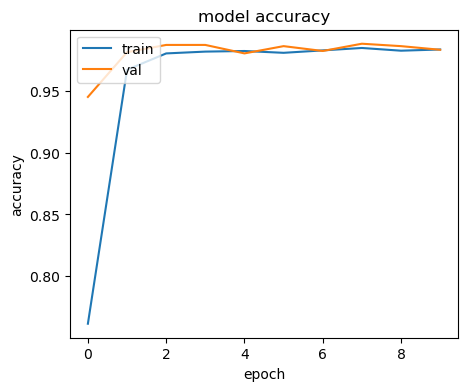

In [280]:
plt.figure(figsize=(5,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

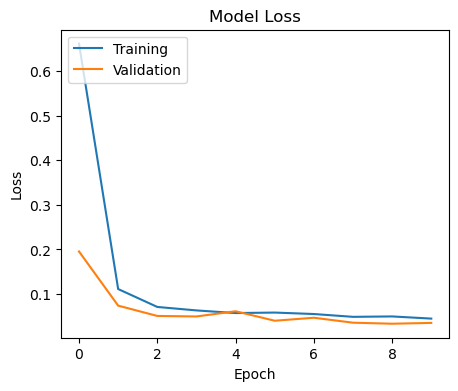

In [281]:
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [282]:
# Evaluate the 'rnn' model on the test data and retrieve the loss and accuracy
loss, accuracyRNN = rnn.evaluate(X_test, y_test)
accuracyRNN= np.round(accuracyRNN * 100,5)
print("Accuracy: %.2f%%" % (accuracyRNN))

40/40 [==============================] - 0s 3ms/step - loss: 0.0570 - accuracy: 0.9875
Accuracy: 98.75%


In [283]:
# Predict on the test set
y_pred = rnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

40/40 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       743
           1       0.98      0.99      0.99       533

    accuracy                           0.99      1276
   macro avg       0.99      0.99      0.99      1276
weighted avg       0.99      0.99      0.99      1276



In [284]:
modelScores.loc[len(modelScores)] = ['Recurret NN', accuracyRNN]

## Gated Recurrent Unit (GRU)

GRU is designed to model sequential data by allowing information to be selectively remembered or forgotten over time. GRUs are used in tasks where sequence data is prevalent.

In [285]:
# Set the random seed for reproducibility in Keras
keras.utils.set_random_seed(0)

In [286]:
# Create a sequential model 'gru' using Keras
gru = keras.Sequential([
    # Add a GRU layer with 32 units and specify the input shape
    layers.GRU(32, input_shape=(X_test.shape[1], 1)),
    # Add a Dense layer with 10 units and ReLU activation function
    layers.Dense(10, activation='relu'),
    # Add a Dense layer with 4 units and sigmoid activation function
    layers.Dense(4, activation='sigmoid')
])

In [287]:
# Compile the 'gru' model with specified loss function and metrics
gru.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# Display a summary of the architecture and parameters of the 'gru' model
gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
 dense_5 (Dense)             (None, 4)                 44        
                                                                 
Total params: 3734 (14.59 KB)
Trainable params: 3734 (14.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [288]:
# Train the 'gru' model on the training data with 10 epochs and 20% validation split
history = gru.fit(X_train, y_train, epochs = 10, validation_split=0.20)

Epoch 1/10
128/128 [==============================] - 3s 11ms/step - loss: 1.2350 - accuracy: 0.4167 - val_loss: 1.0498 - val_accuracy: 0.4319
Epoch 2/10
128/128 [==============================] - 1s 8ms/step - loss: 0.9190 - accuracy: 0.4341 - val_loss: 0.7547 - val_accuracy: 0.4574
Epoch 3/10
128/128 [==============================] - 1s 8ms/step - loss: 0.6615 - accuracy: 0.6645 - val_loss: 0.5479 - val_accuracy: 0.7747
Epoch 4/10
128/128 [==============================] - 1s 9ms/step - loss: 0.4866 - accuracy: 0.8017 - val_loss: 0.5009 - val_accuracy: 0.7434
Epoch 5/10
128/128 [==============================] - 1s 9ms/step - loss: 0.4141 - accuracy: 0.8191 - val_loss: 0.3822 - val_accuracy: 0.8296
Epoch 6/10
128/128 [==============================] - 1s 8ms/step - loss: 0.3776 - accuracy: 0.8409 - val_loss: 0.3368 - val_accuracy: 0.8550
Epoch 7/10
128/128 [==============================] - 1s 8ms/step - loss: 0.3513 - accuracy: 0.8512 - val_loss: 0.3560 - val_accuracy: 0.8423
Epoch

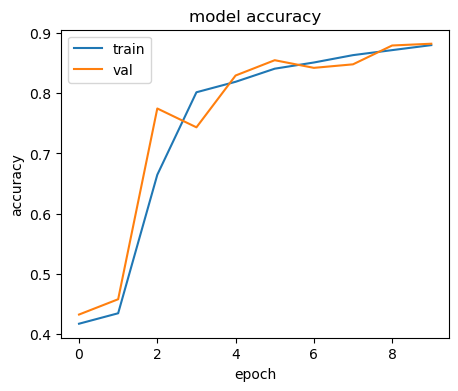

In [289]:
plt.figure(figsize=(5,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

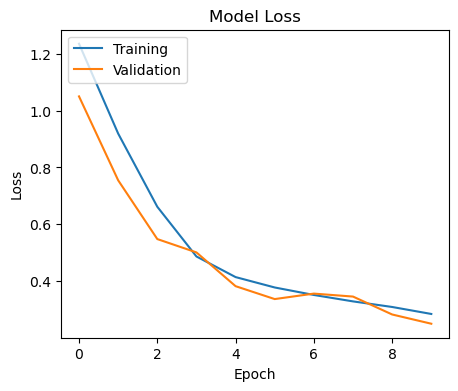

In [290]:
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [291]:
# Predict on the test set
y_pred = gru.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

40/40 [==============================] - 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       743
           1       0.86      0.91      0.88       533

    accuracy                           0.90      1276
   macro avg       0.90      0.90      0.90      1276
weighted avg       0.90      0.90      0.90      1276



In [292]:
loss, accuracyGRU = gru.evaluate(X_test, y_test)
accuracyGRU= np.round(accuracyGRU * 100,5)
print("Accuracy: %.2f%%" % (accuracyGRU))

40/40 [==============================] - 0s 4ms/step - loss: 0.2534 - accuracy: 0.9013
Accuracy: 90.13%


In [293]:
modelScores.loc[len(modelScores)] = ['Gated Recurrent Unit', accuracyGRU]

# **Models Performance**

In [294]:
modelScores.sort_values(by= 'Accuracy', ascending=False, inplace=True)
modelScores

Models  Accuracy
1              CatBoost  99.21630
6               XGBoost  98.98119
3           Recurret NN  98.74608
2   Variational Encoder  97.17869
4  Gated Recurrent Unit  90.12539

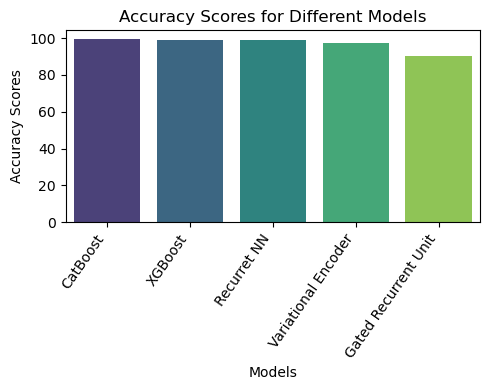

In [295]:
plt.figure(figsize=(5, 4))
sns.barplot(x='Models', y='Accuracy', data=modelScores, palette='viridis')
plt.xticks(rotation=55, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Models')
plt.ylabel('Accuracy Scores')
plt.title('Accuracy Scores for Different Models')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()